# Plot track intensity over time 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys 
import os
sys.path.append('../src/')
from intensity_time_plots import filter_track_ids_by_length_ranges, random_track_ids
from intensity_time_plots import intensity_time_plot, createBufferForLifetimeCohort
from intensity_time_plots import createBufferForLifetimeCohort_normalized, cumulative_plots

In [19]:
###### Set the following variables #######


# Background intensity for each channel

background_channel_1 = 240
background_channel_2 = 150
background_channel_3 = 170

# framerate (in milliseconds)

framerate_msec = 2300

# protein names (optional)

channel1_name = 'Arp2/3-Halo'
channel2_name = 'Dynamin2-tagGFP2'
channel3_name = 'AP2-tagRFPt'

### Which type of intensity to report per spot
Options:
* voxel_sum_adjusted (default): background-subtracted sum intensity
* voxel_sum: sum intensity
* peak_mean: mean intensity
* peak_max: max intensity


In [20]:
value_to_plot = 'voxel_sum_adjusted'
# value_to_plot = 'voxel_sum'
# value_to_plot = 'peak_mean'
# value_to_plot = 'peak_max'

if value_to_plot == 'voxel_sum_adjusted':
    background_channel_1 = 0
    background_channel_2 = 0
    background_channel_3 = 0

# use this list to see all possible values to plot
# track_df.columns

In [21]:
# This assumes that your notebook is inside 'Jupyter Notebooks', which is at the same level as 'test_data'
base_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'movie_data')

zarr_directory = 'zarr_file/all_channels_data'
zarr_full_path = os.path.join(base_dir, zarr_directory)

input_directory = 'datasets'
input_file_name = 'track_df_cleaned_final_full.pkl'
input_directory_all_tracks_full = os.path.join(base_dir,input_directory, input_file_name)

input_file_name = 'filtered_tracks_final.pkl'
input_directory_full_filtered_tracks = os.path.join(base_dir,input_directory , input_file_name)

In [22]:
track_df = pd.read_pickle(input_directory_all_tracks_full)
filtered_tracks = pd.read_pickle(input_directory_full_filtered_tracks)

Set which region to plot. Default is 'All'

In [23]:
# region_to_plot = 'Apical'
# region_to_plot = 'Lateral'
# region_to_plot = 'Basal'
region_to_plot = 'All'

if region_to_plot != 'All':
    filtered_tracks_all = filtered_tracks
    filtered_tracks = filtered_tracks_all[filtered_tracks_all['membrane_region'] == region_to_plot]

print('You are about to plot the following region: ', region_to_plot)


You are about to plot the following region:  All


Define cohort sizes

In [24]:
# range of track lengths to plot in each cohort, in frames
custom_length_ranges = [[5, 10], [11,15], [16, 20], [21, 25], [26, 30], [31, 40], [41,90]]

## Pick which channel(s) to plot

In [25]:
# by default you always plot channel 3 positive (fixing this)

# e.g. [True, True] to plot all three channels
# or [True, False] to plot channels 1 and 2

channels_to_plot = [True, True]

tracks_channel_subset = filtered_tracks[(filtered_tracks['channel1_positive'] == channels_to_plot[0]) &
                                 (filtered_tracks['channel2_positive'] == channels_to_plot[1])]

# will get this to work:

# e.g. [True, True, True] to plot all three channels
# or [True, False, True] to plot channels 1 and 3

# channels_to_plot = [True, True, True]

# tracks_channel_subset = filtered_tracks[(filtered_tracks['channel1_positive'] == channels_to_plot[0]) &
#                                  (filtered_tracks['channel2_positive'] == channels_to_plot[1]) &
#                                  (filtered_tracks['channel3_positive'] == channels_to_plot[2])]

tracks_channel_subset.head()

track_id  track_length  track_start  track_end     c3_peak     c2_peak  \
7310      7310            35            1         35  277.573333  152.022222   
7472      7472            37            1         37  225.902222  155.471111   
7509      7509            13            1         13  186.148387  165.795349   
7776      7776            32            1         32  224.897778  152.724444   
7806      7806            23            1         23  257.231111  158.382222   

         c1_peak  c3_peak_frame  c2_peak_frame  c1_peak_frame  ...  \
7310  283.368889              5              6             31  ...   
7472  265.320000             21             22             28  ...   
7509  325.664516              5              7              5  ...   
7776  623.217778             20             17             23  ...   
7806  534.324444              8             12             10  ...   

      max_distance_between_two_points  C3_adjusted_voxel_sum_positive  \
7310                         8.366600                           False   
7472                         8.774964                            True   
7509                         7.615773                            True   
7776                         6.782330                            True   
7806                         6.324555                           False   

      C2_adjusted_voxel_sum_positive  C1_adjusted_voxel_sum_positive  \
7310                           False                           False   
7472                           False                           False   
7509                           False                           False   
7776                           False                           False   
7806                           False                           False   

      max_z_movement  max_y_movement  max_x_movement  channel2_positive  \
7310             7.0             5.0             4.0               True   
7472             6.0             4.0             6.0               True   
7509             1.0             7.0             3.0               True   
7776             4.0             3.0             6.0               True   
7806             4.0             6.0             3.0               True   

      channel1_positive  membrane_region  
7310               True          Lateral  
7472               True           Apical  
7509               True           Apical  
7776               True           Apical  
7806               True           Apical  

[5 rows x 24 columns]

In [26]:
track_id_arrays = filter_track_ids_by_length_ranges(dataframe = tracks_channel_subset, track_length_buckets = custom_length_ranges, 
                                 track_id_col_name = 'track_id', track_length_col_name = 'track_length')

print(f'number of tracks between [5,10] frames long are {len(track_id_arrays[0])}')
print(f'number of tracks between [11,15] frames long are {len(track_id_arrays[1])}')
print(f'number of tracks between [16,20] frames long are {len(track_id_arrays[2])}')
print(f'number of tracks between [21,25] frames long are {len(track_id_arrays[3])}')
print(f'number of tracks between [26,30] frames long are {len(track_id_arrays[4])}')
print(f'number of tracks between [31,40] frames long are {len(track_id_arrays[5])}')
print(f'number of tracks between [41,90] frames long are {len(track_id_arrays[6])}')

number of tracks between [5,10] frames long are 86
number of tracks between [11,15] frames long are 94
number of tracks between [16,20] frames long are 75
number of tracks between [21,25] frames long are 36
number of tracks between [26,30] frames long are 23
number of tracks between [31,40] frames long are 34
number of tracks between [41,90] frames long are 16


In [27]:
# Statistics of track lengths for each condition

Plot random tracks

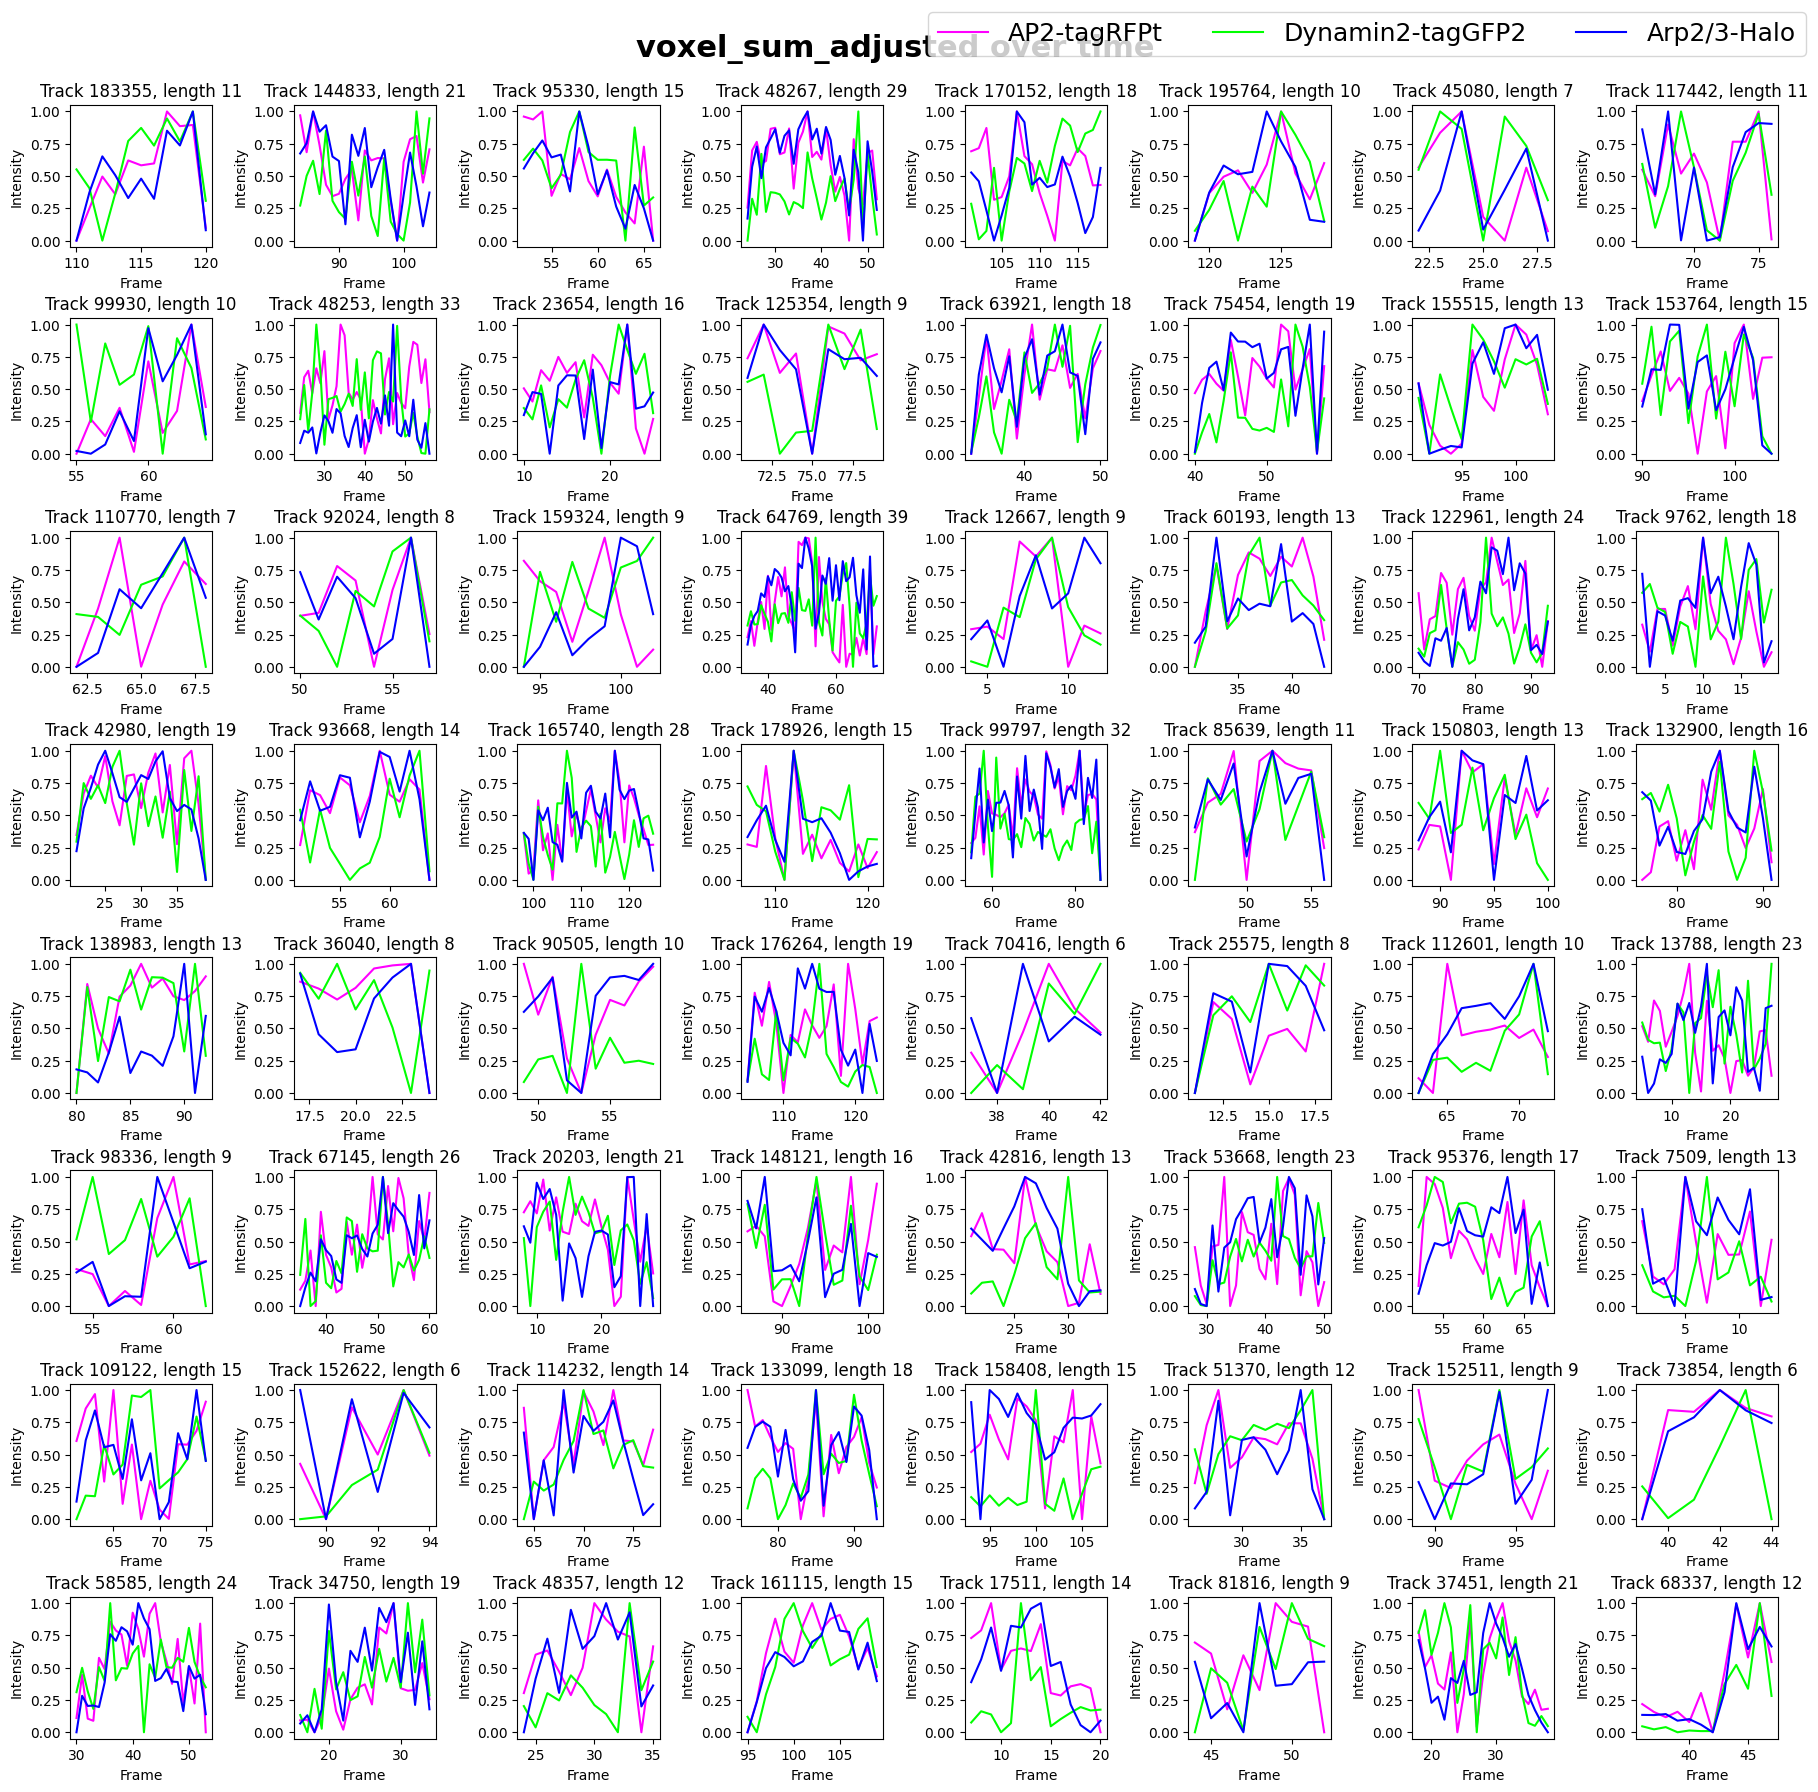

In [28]:
# set 'normalized = False' to plot raw intensities

random_tracks = random_track_ids(dataframe = tracks_channel_subset, desired_length = [0, np.inf], 
                                 track_length_col_name = 'track_length', track_id_col_name = 'track_id', 
                                num_to_select = 64)

intensity_time_plot(dataframe = track_df, tracks_to_plot = random_tracks, 
intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id', 
frame_col_name = 'frame', channels_to_plot = 3, legend_values = [channel3_name, channel2_name, channel1_name],
line_colors = ['magenta', 'lime', 'blue'], graph_title = f'{value_to_plot}', normalized=True)

In [12]:
# Uncomment to plot random tracks from a specific lifetime cohort
# ## Pick which lifetime cohort to plot from, between 0 (shortest tracks) to 6 (longest tracks)

# cohort_to_plot = 3

# print("plotting tracks between " + str(custom_length_ranges[3][0]) + " and " + str(custom_length_ranges[3][1]) + " frames long")

# ### Select random track ids of a desired length 

# random_tracks = random_track_ids(dataframe = channel_subset, desired_length = custom_length_ranges[cohort_to_plot], 
#                                  track_length_col_name = 'track_length', track_id_col_name = 'track_id', 
#                                 num_to_select = 64)

# ### The amplitude used for plotting is voxel sum from both channels. Minimum voxel sum is subtracted from all values to try and bring starting intensities close to zero

# intensity_time_plot(dataframe = track_df, tracks_to_plot = random_tracks, 
# intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id', 
# frame_col_name = 'frame', channels_to_plot = 3, legend_values = ['Channel 3', 'Channel 2', 'Channel 1'],
# line_colors = ['magenta', 'lime', 'blue'], graph_title = f'{value_to_plot}')

In [13]:
# primary_buffer, secondary_buffer, tertiary_buffer = createBufferForLifetimeCohort(dataframe = track_df ,
# listOfTrackIdsAssignedToCohort = track_id_arrays[2], backgroundIntensity = [background_channel_3, background_channel_2, background_channel_1], 
# intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id')

# # visualize alignment of tracks

# plt.figure(dpi=300)
# plt.title(channel3_name)
# plt.imshow(primary_buffer)

# plt.figure(dpi=300)
# plt.title(channel2_name)
# plt.imshow(secondary_buffer)

# plt.figure(dpi=300)
# plt.title(channel1_name)
# plt.imshow(tertiary_buffer)


## Intensity plots by lifetime cohort

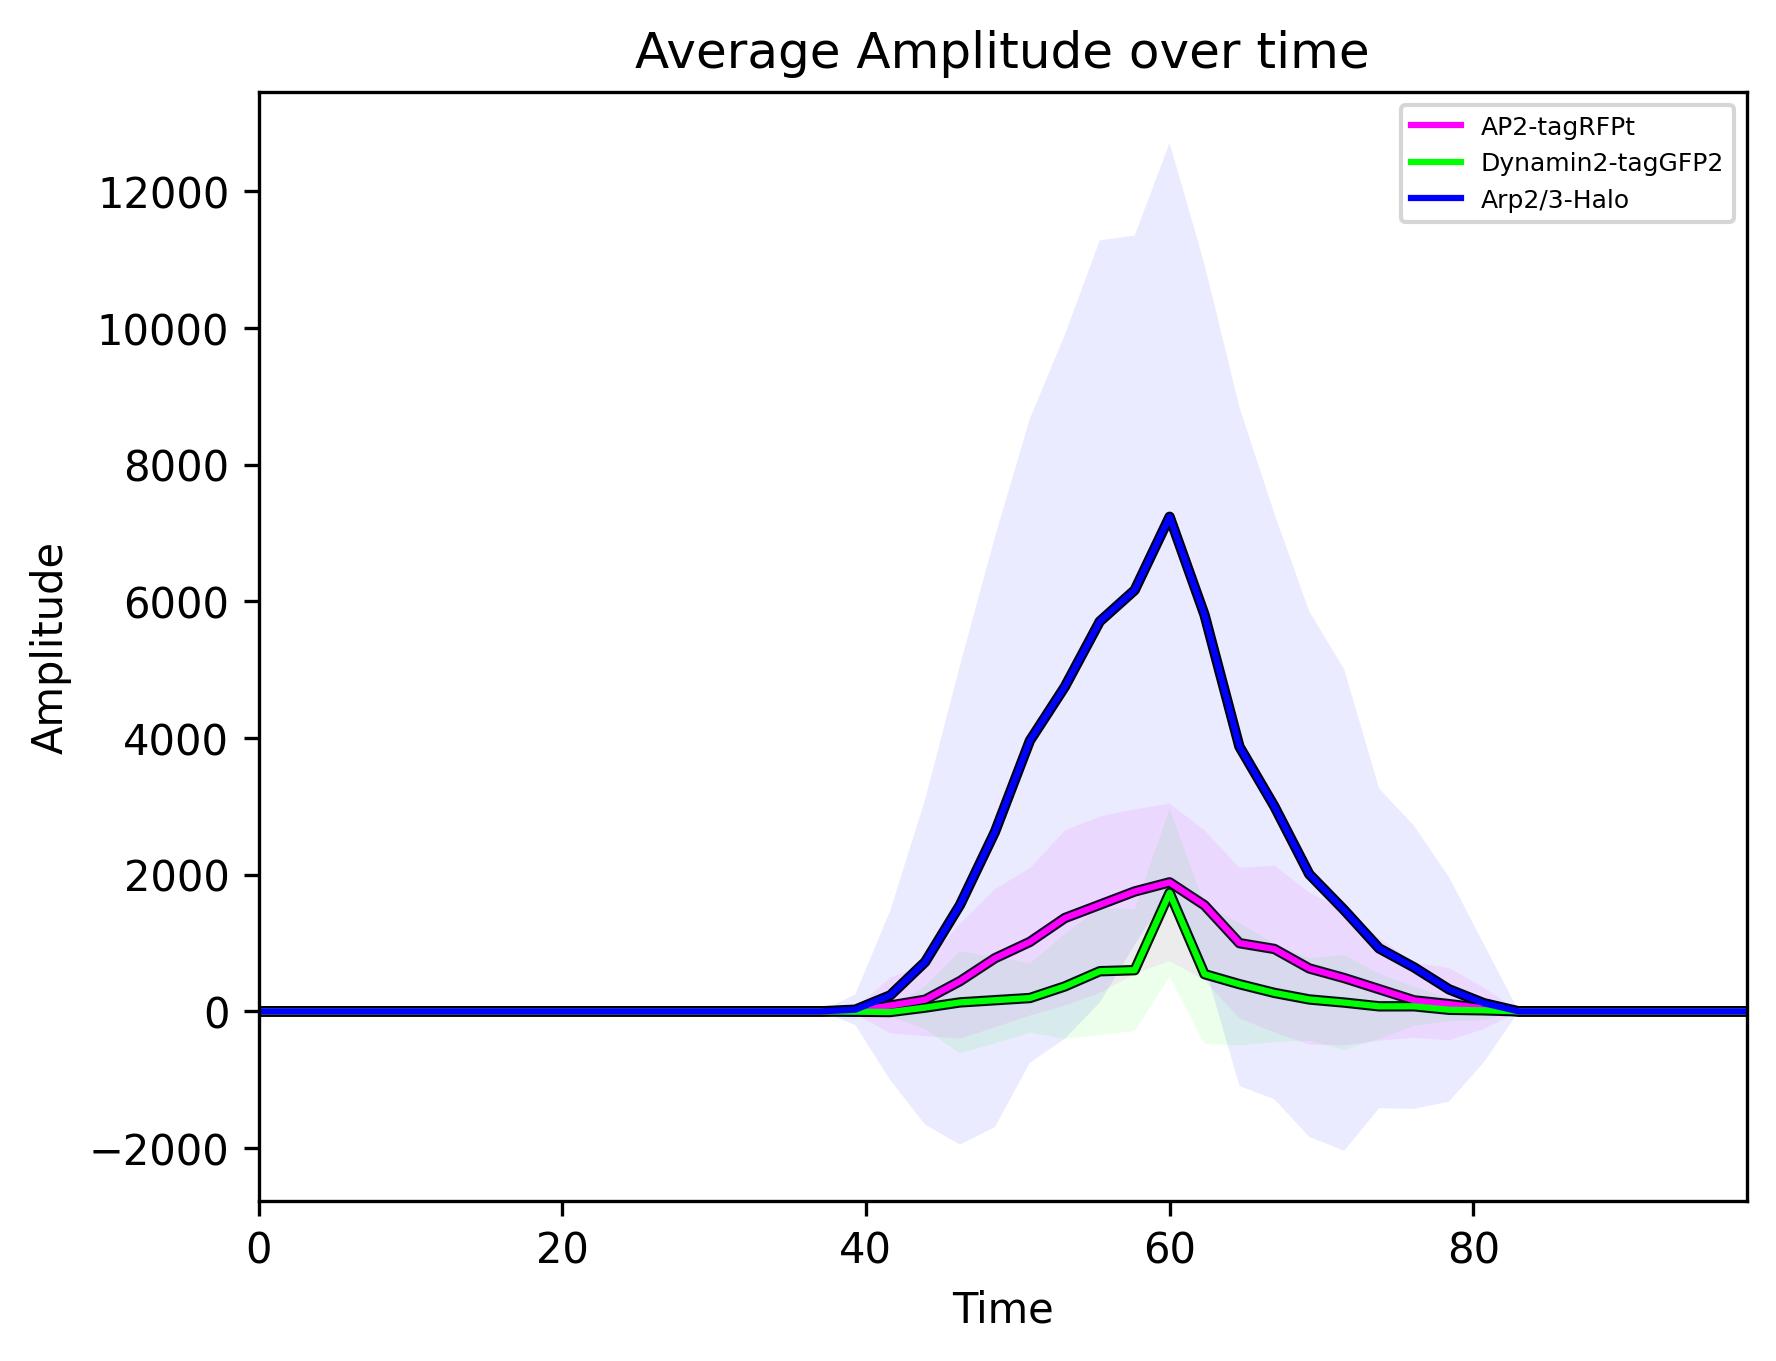

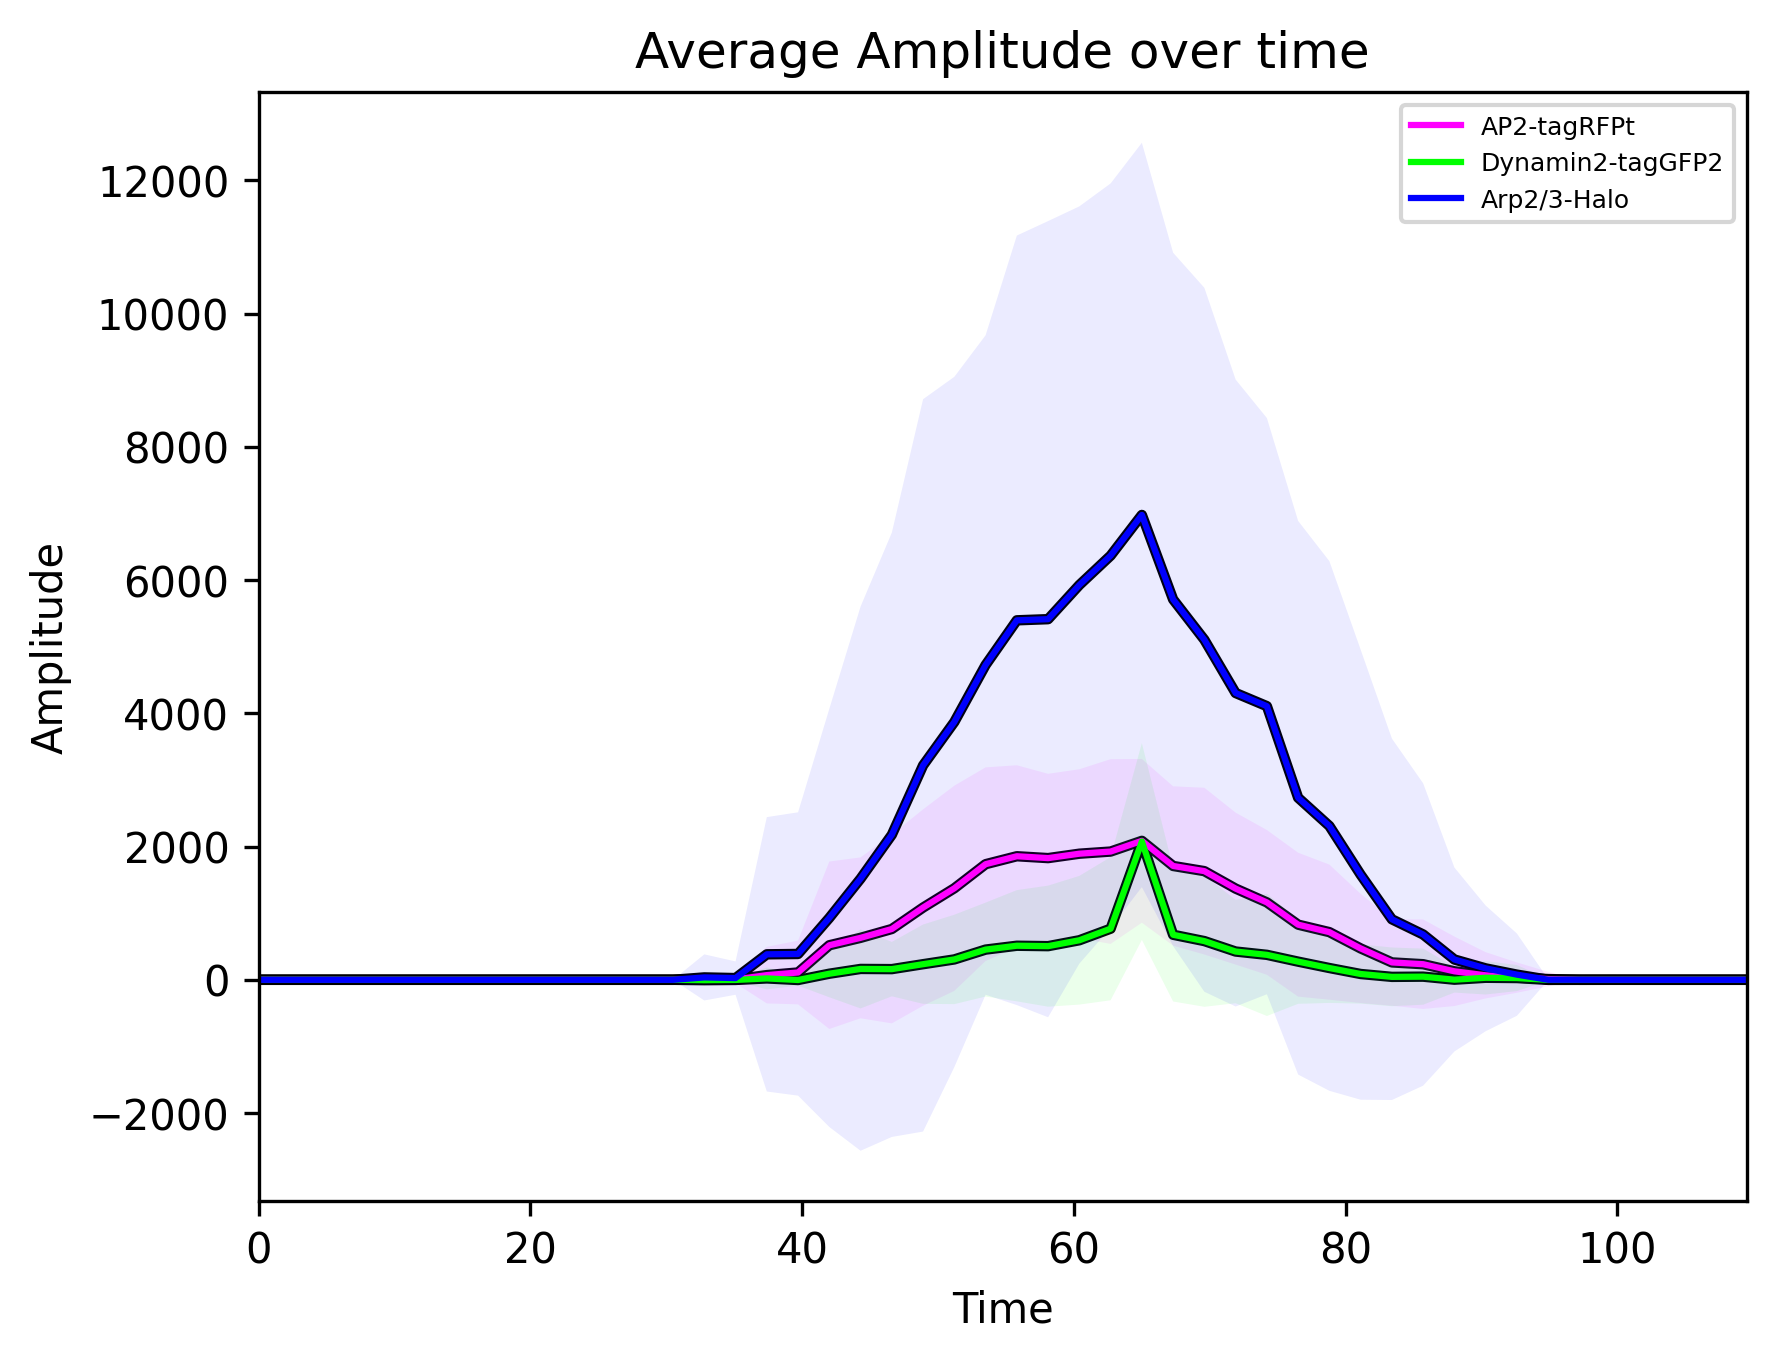

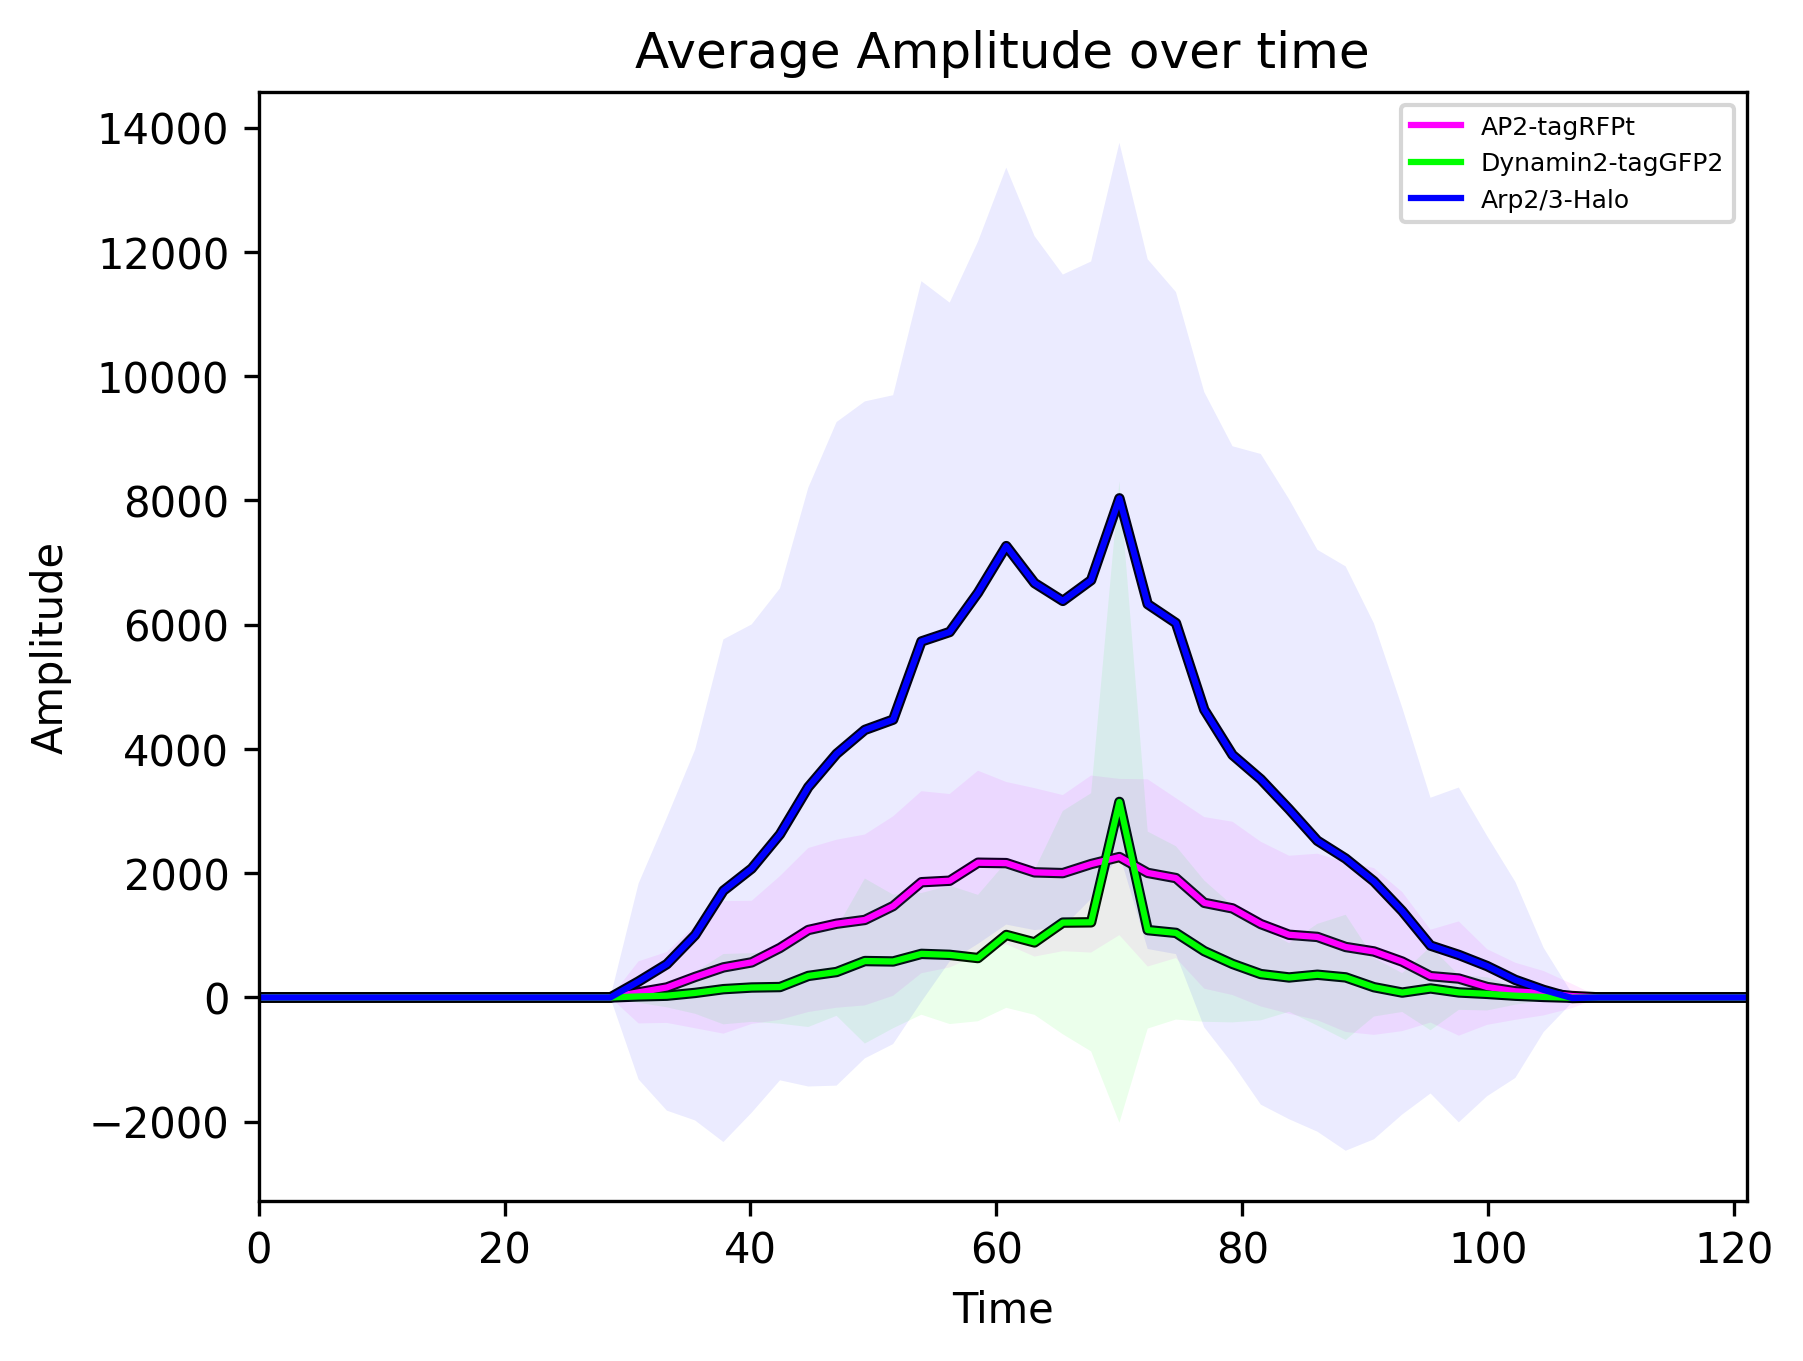

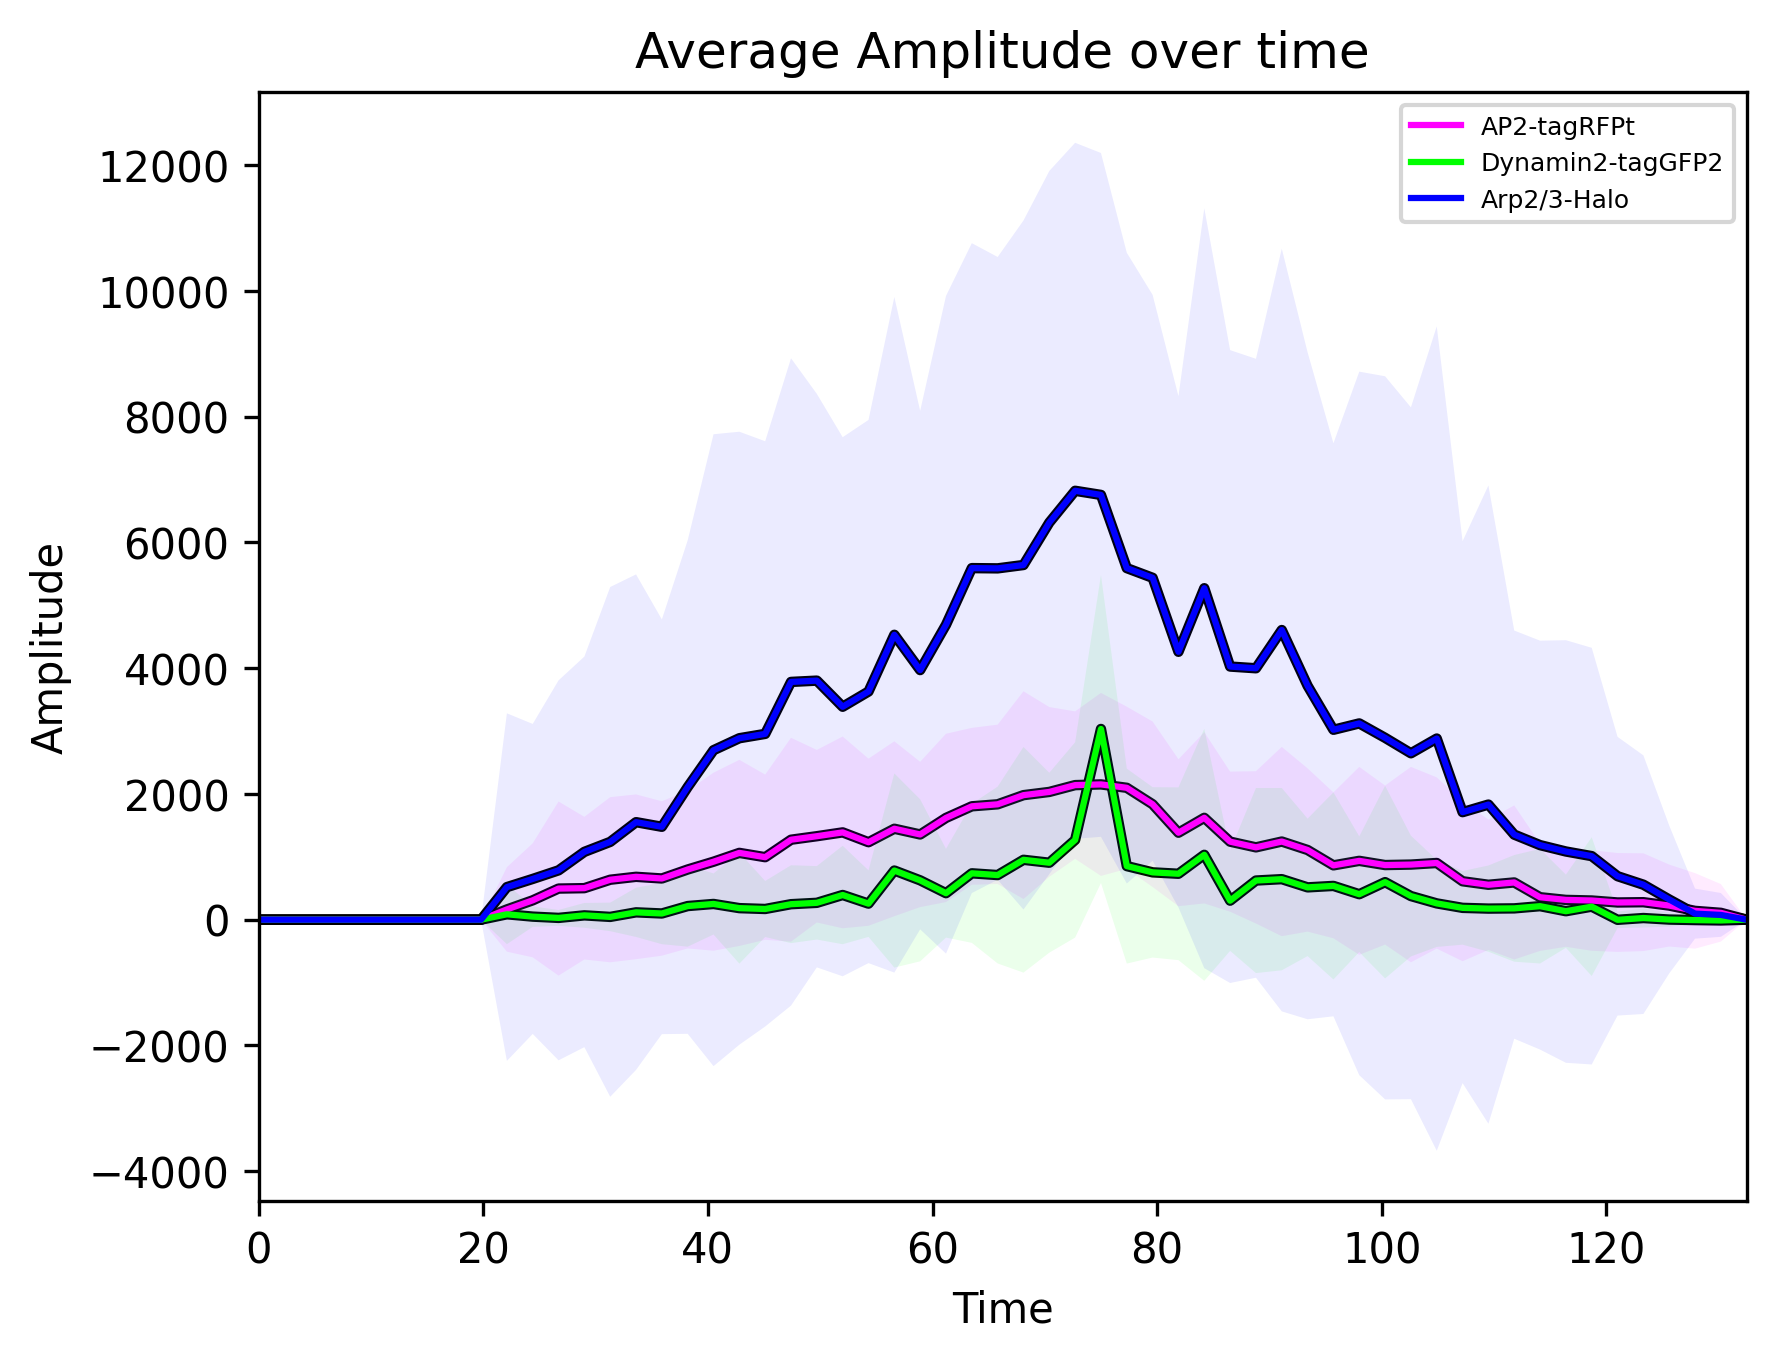

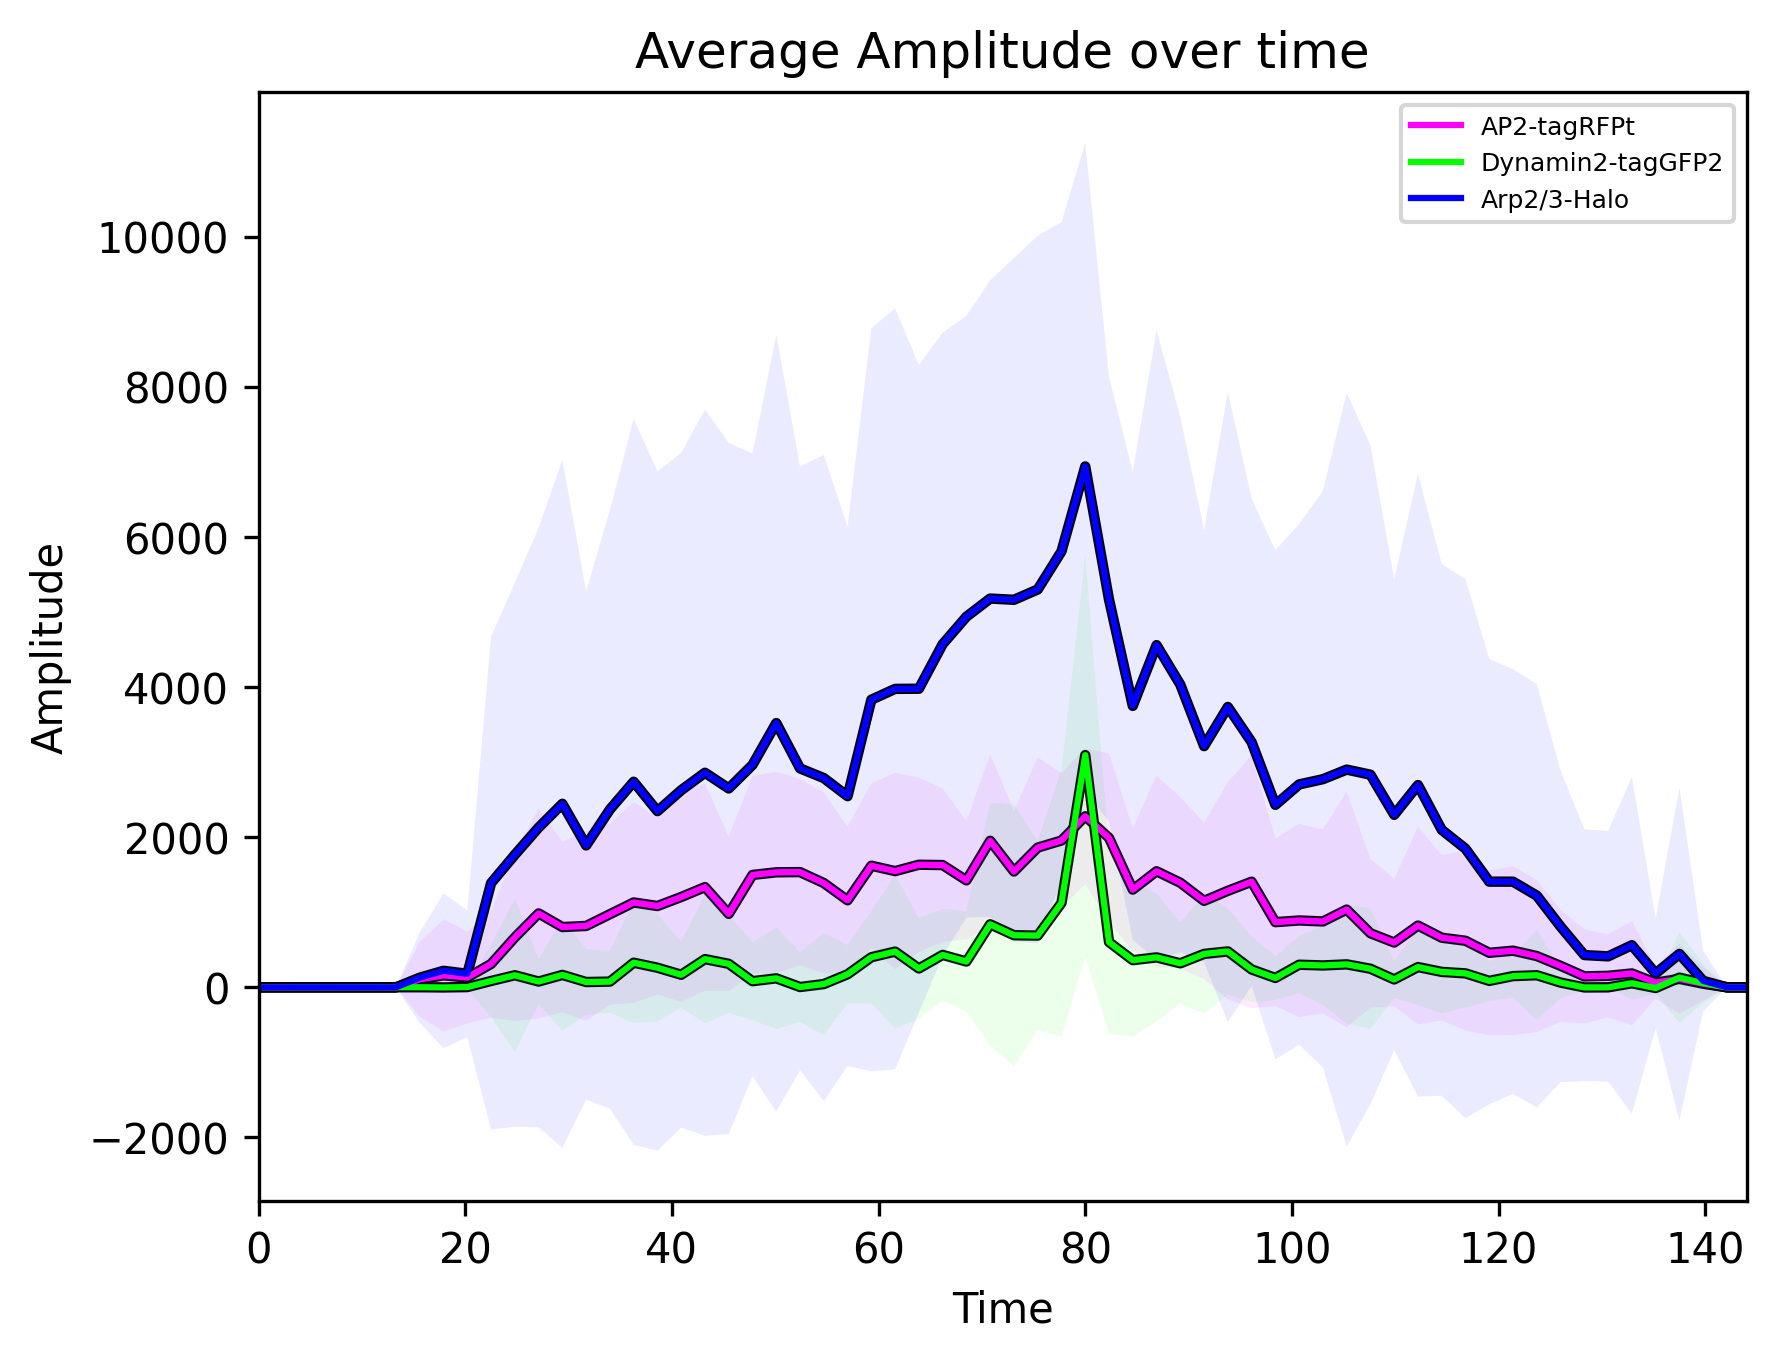

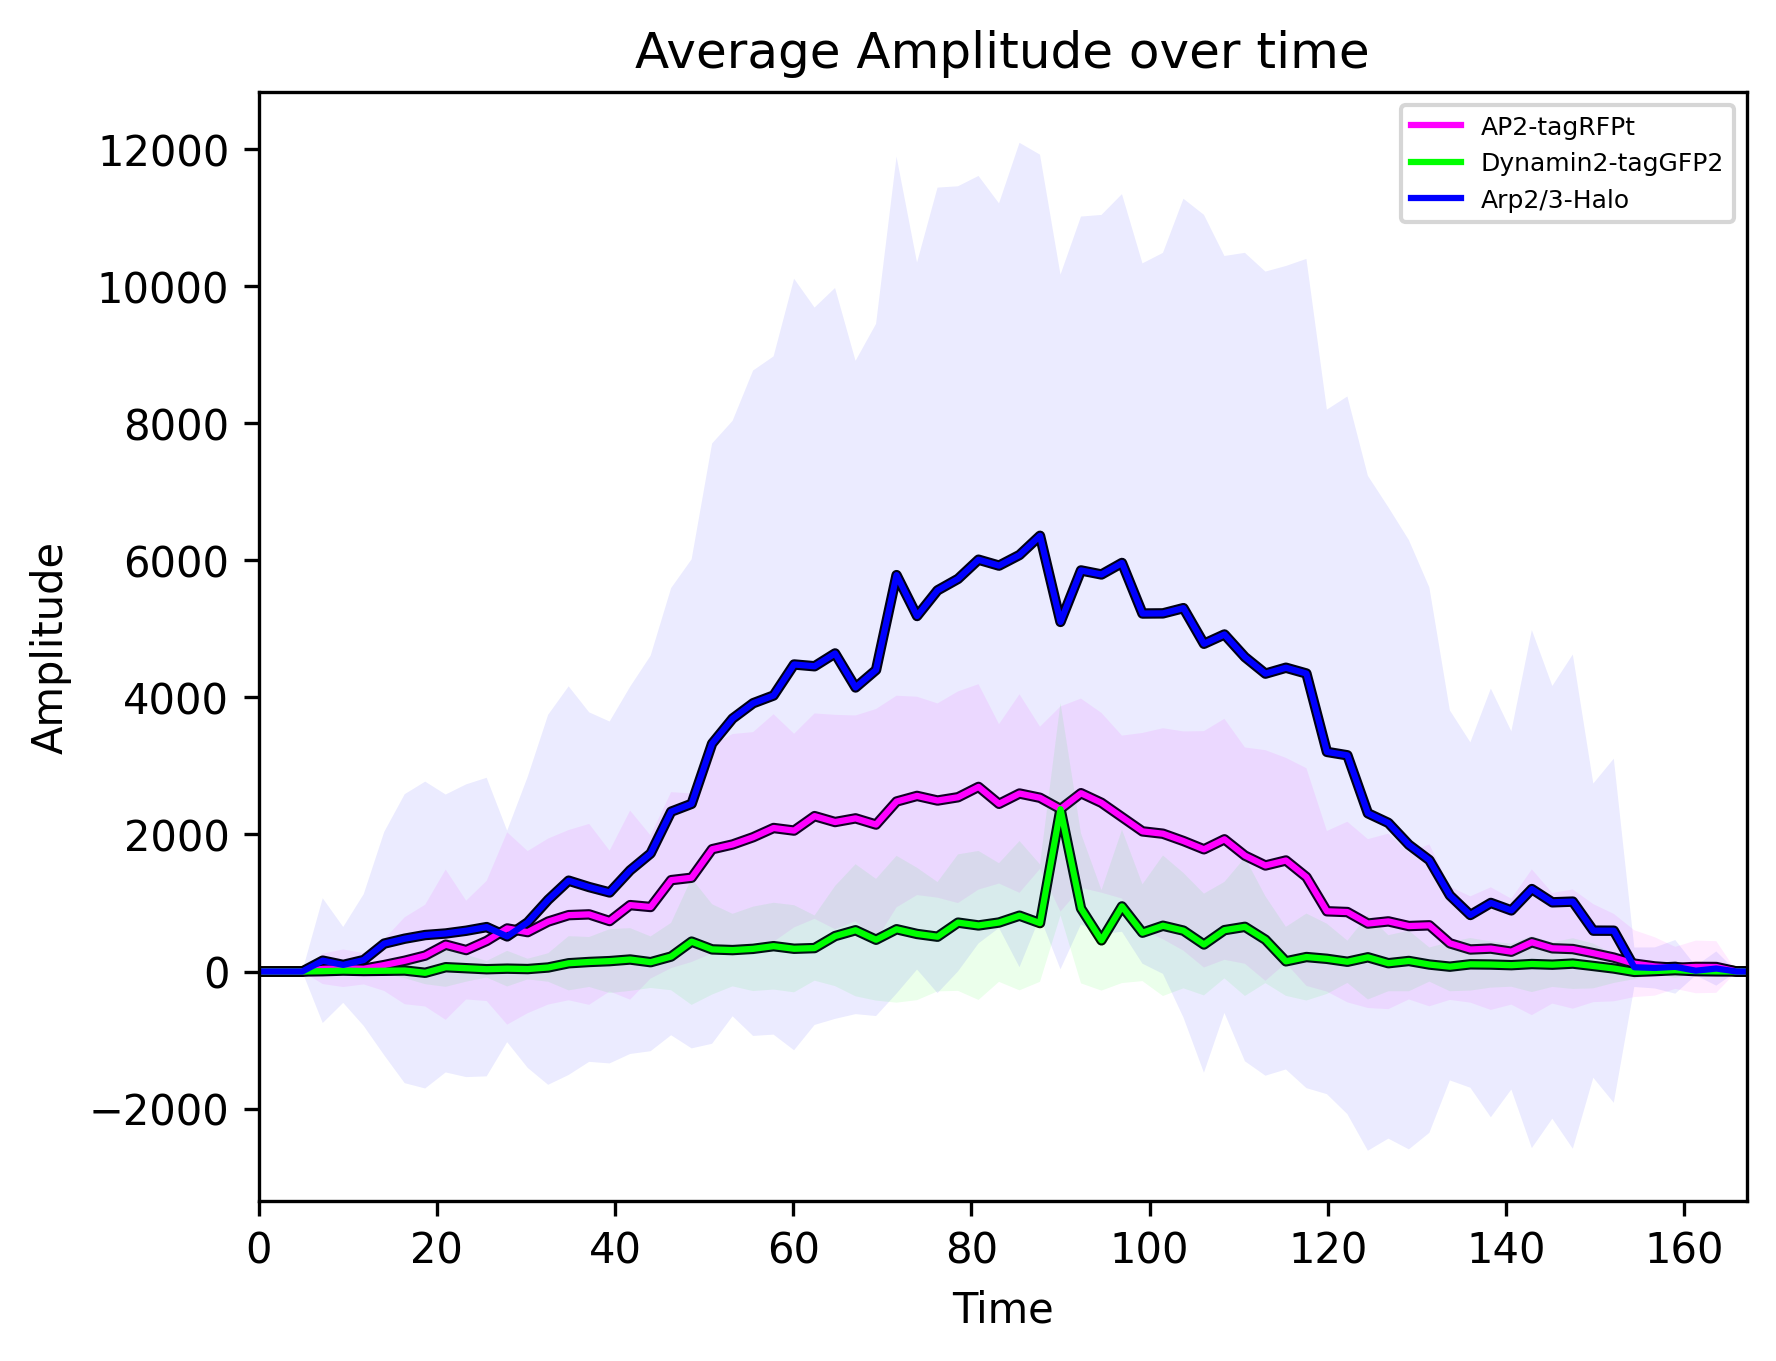

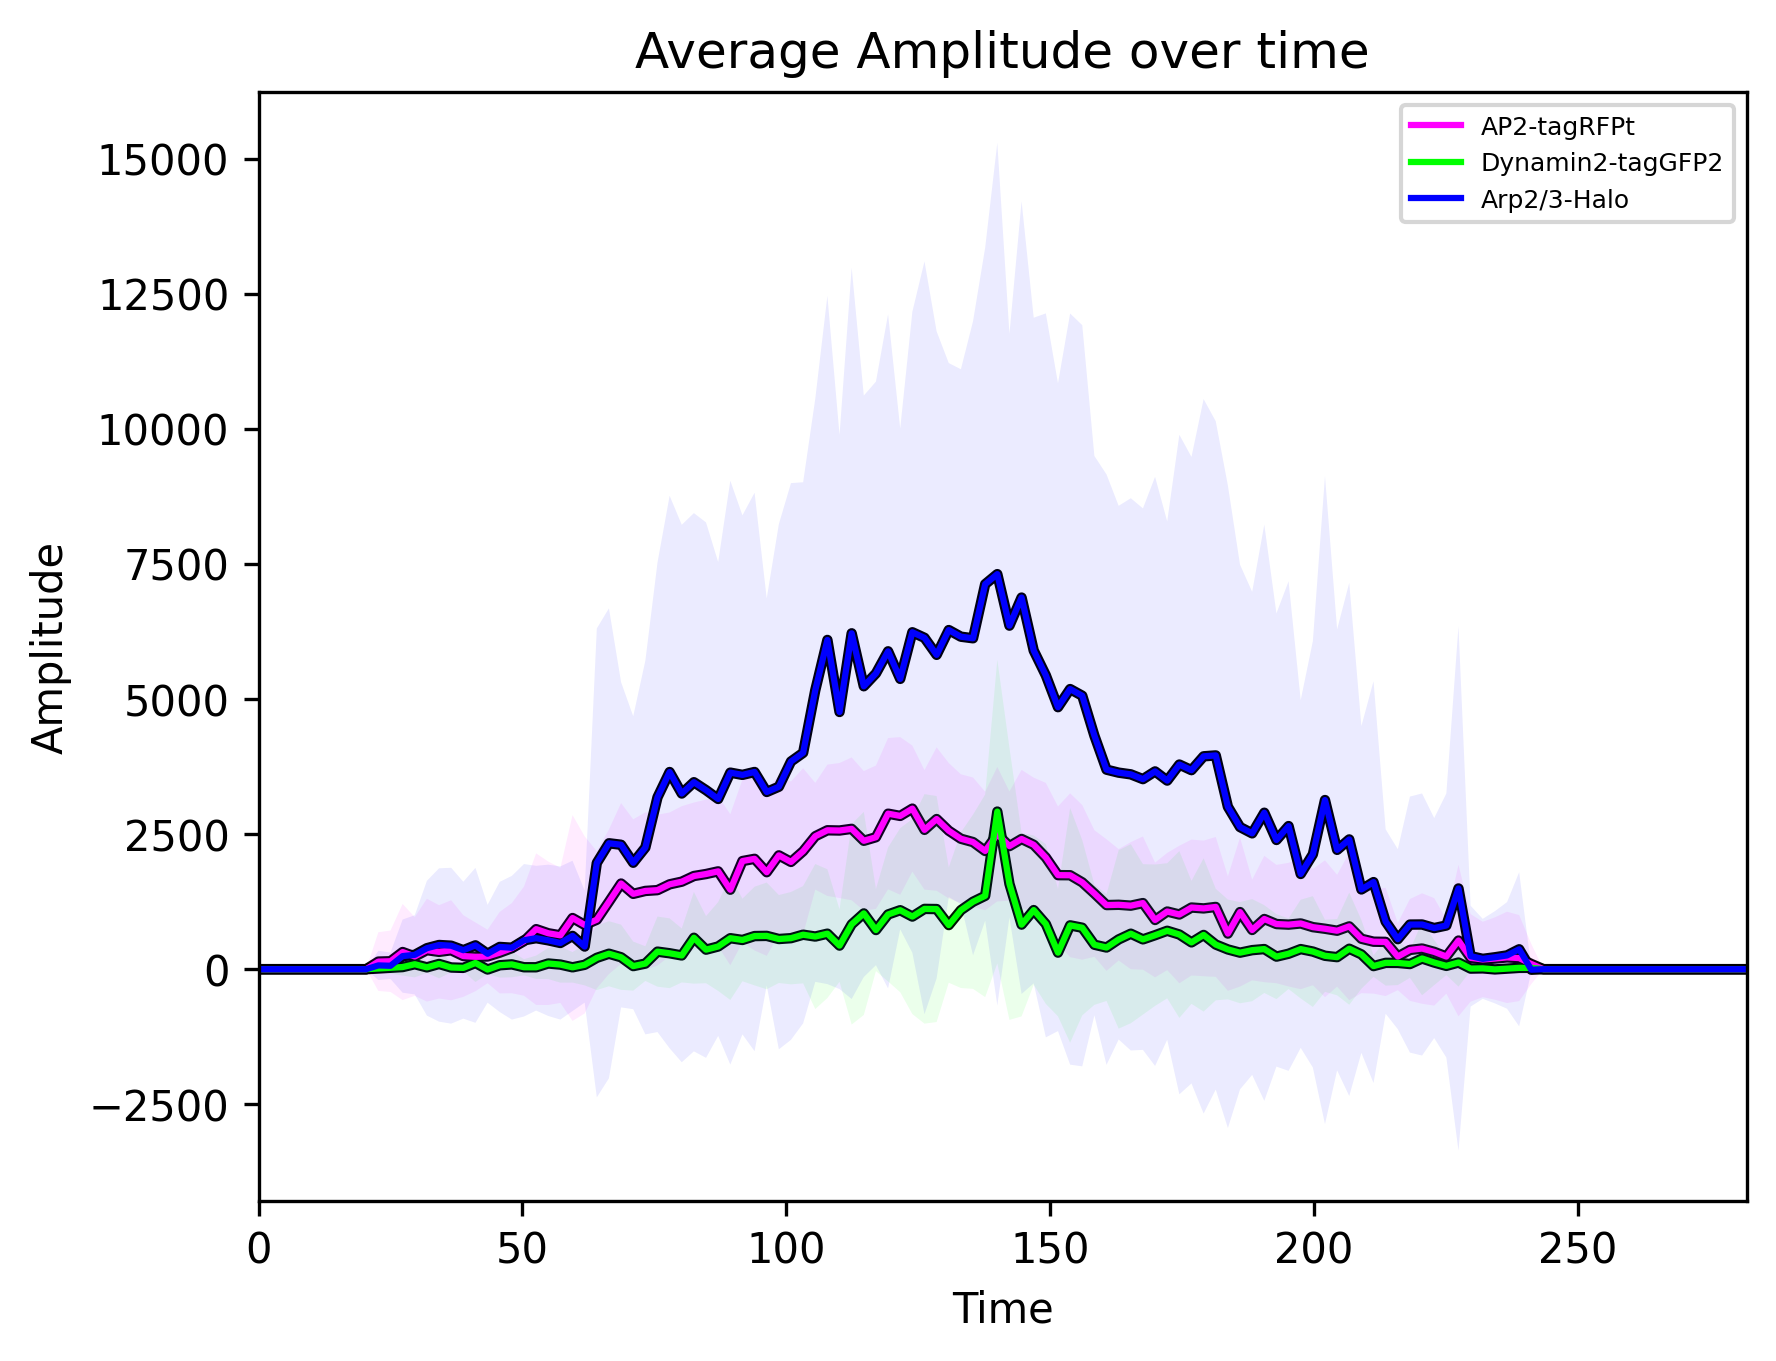

In [29]:
for n, cohort in enumerate(custom_length_ranges):
    primary_buffer, secondary_buffer, tertiary_buffer = createBufferForLifetimeCohort(dataframe = track_df ,
    listOfTrackIdsAssignedToCohort = track_id_arrays[n], 
    intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id')

    cumulative_plots(buffers = [primary_buffer, secondary_buffer, tertiary_buffer],
    background_intensity= [background_channel_1, background_channel_2, background_channel_3], time_shift = 50+cohort[1], framerate_msec = framerate_msec, colors = ['magenta', 'lime', 'blue'], 
                    legend_vals = [channel3_name, channel2_name, channel1_name])
    plt.xlim(0, 75+cohort[1]*framerate_msec/1000)


Normalized

In [15]:
# trying different background intensities

background_channel_1 = 0
background_channel_2 = 0
background_channel_3 = 0

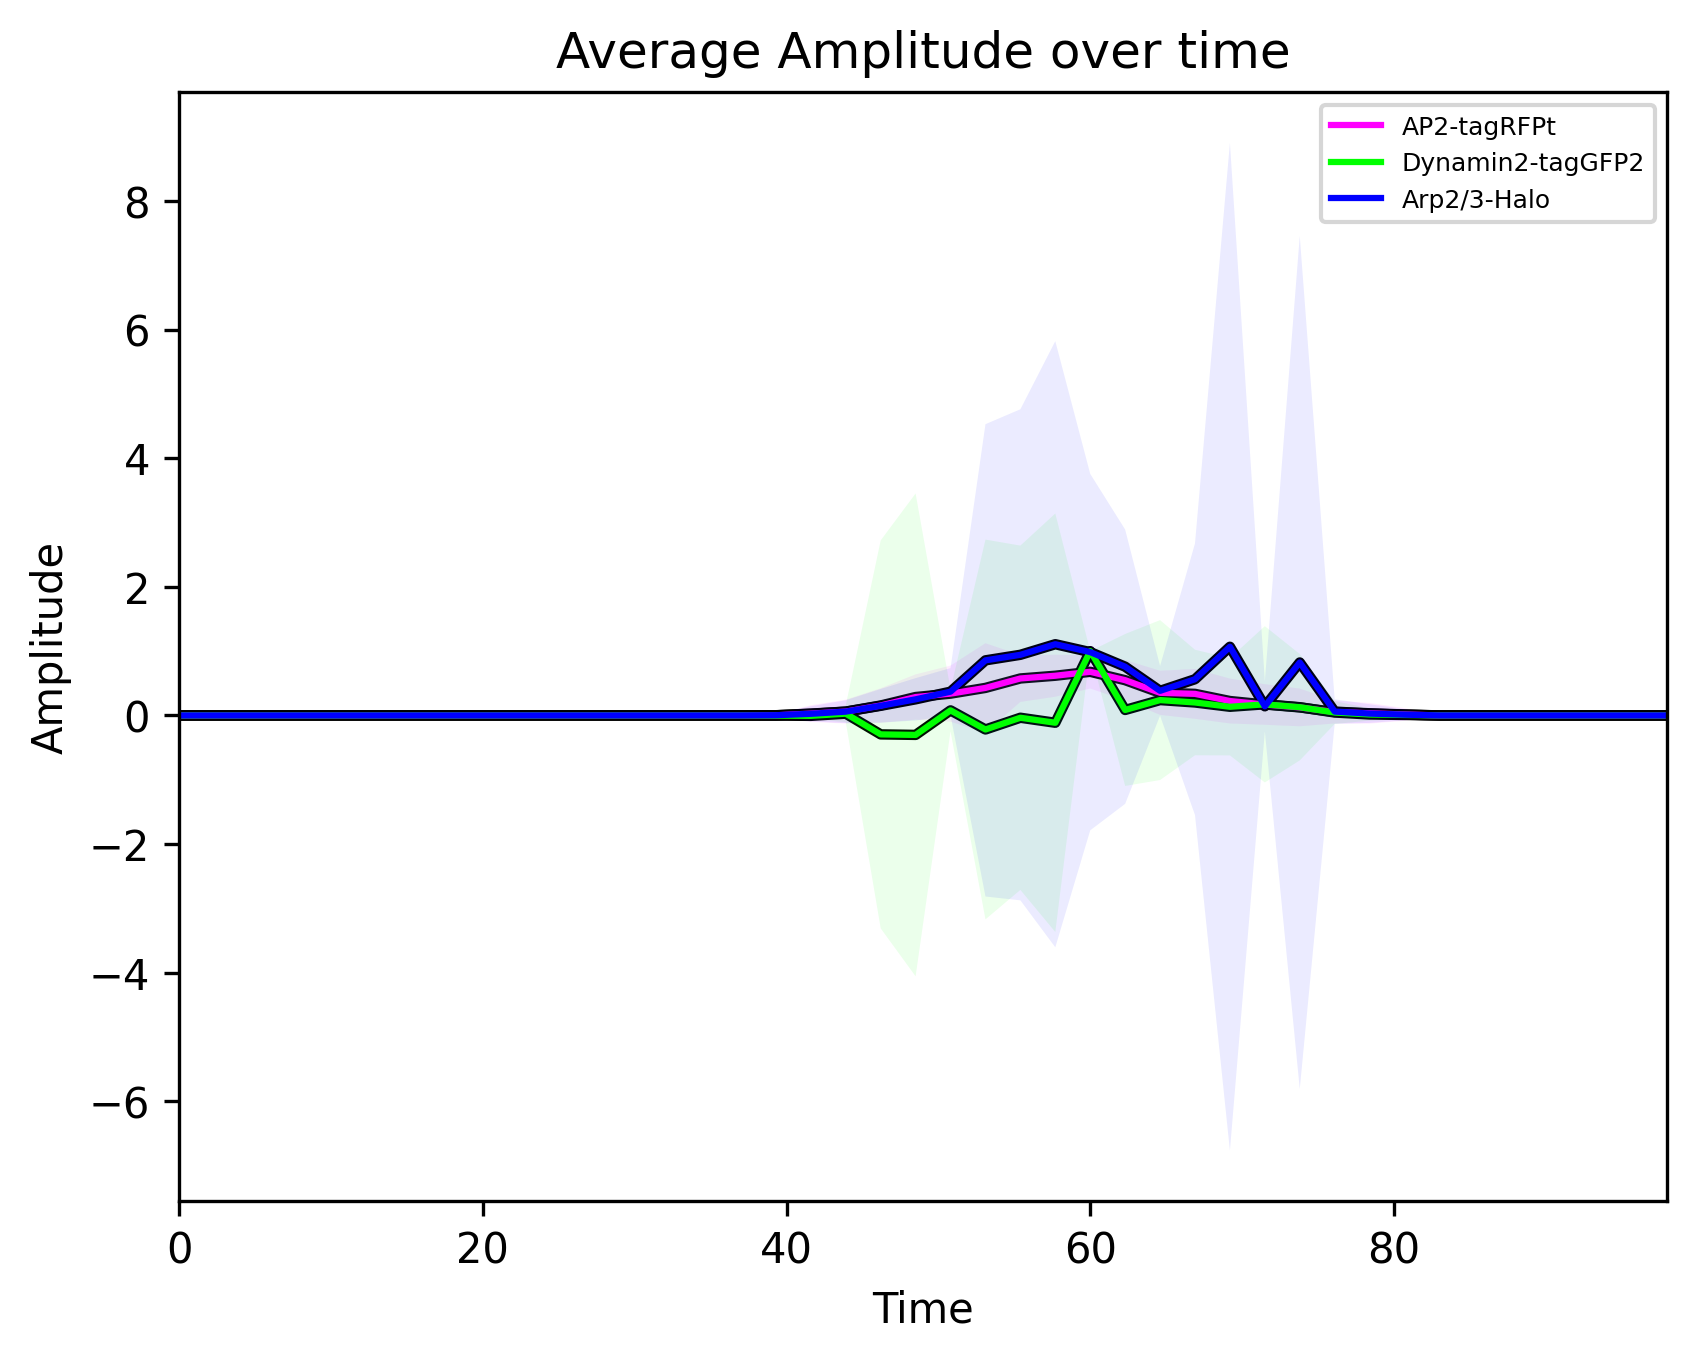

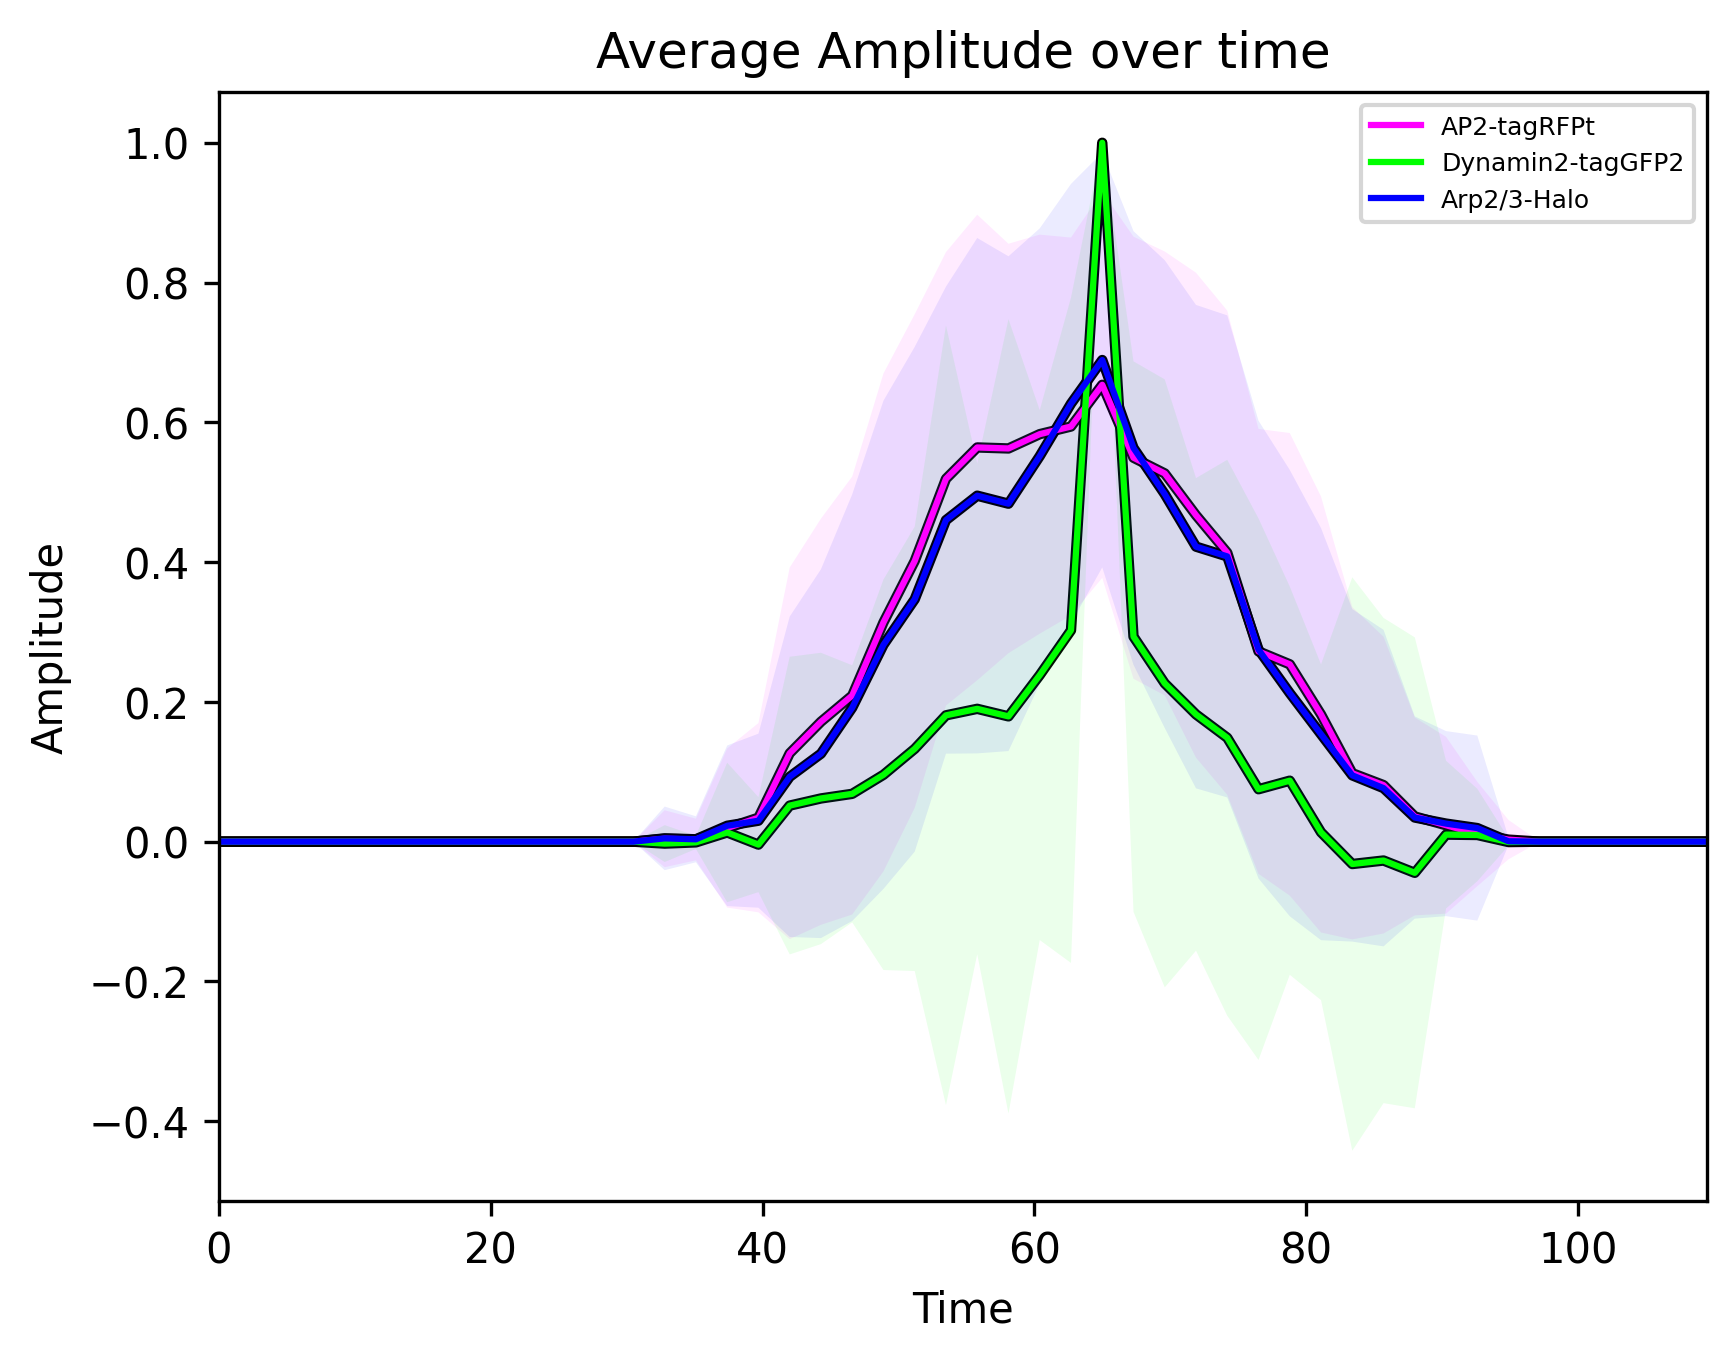

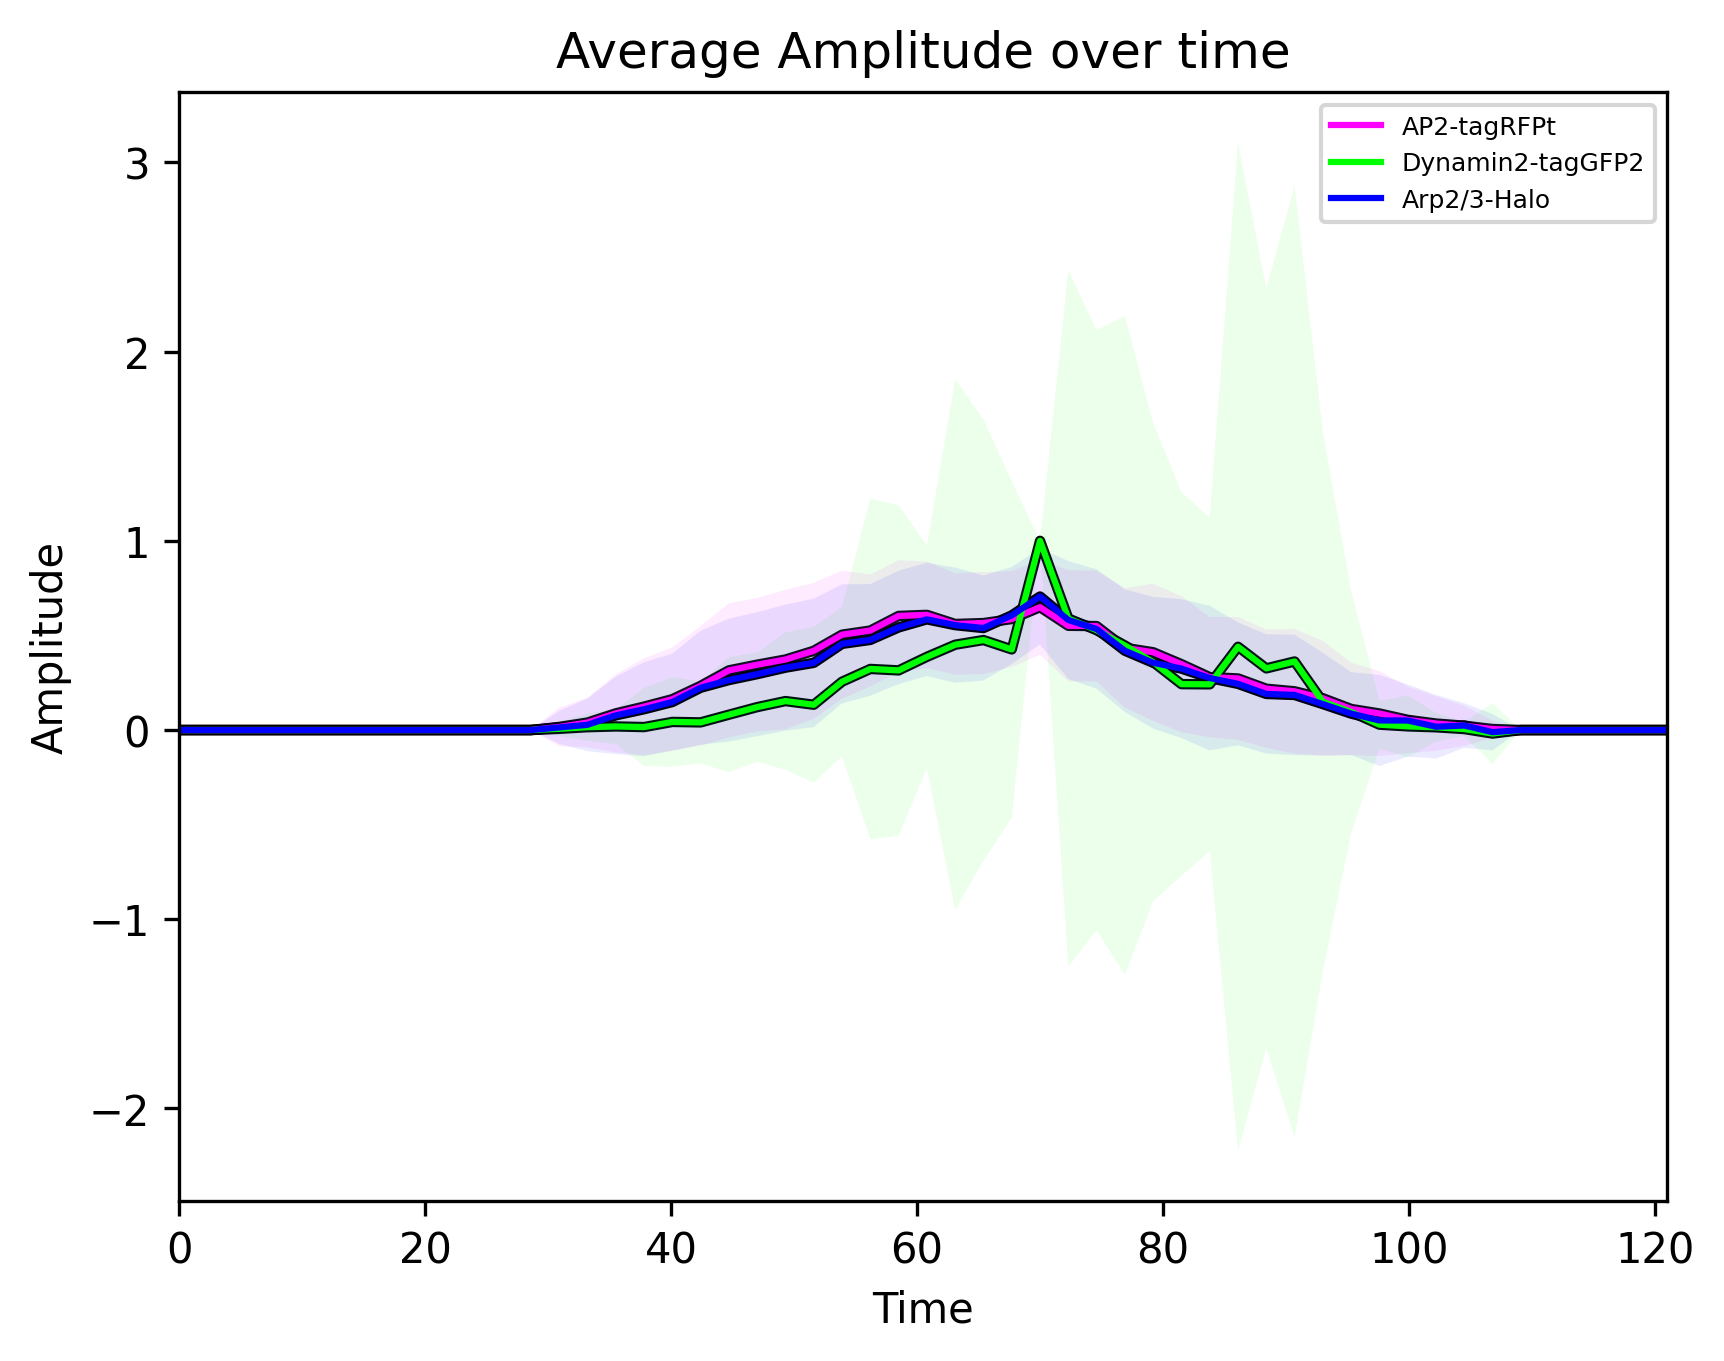

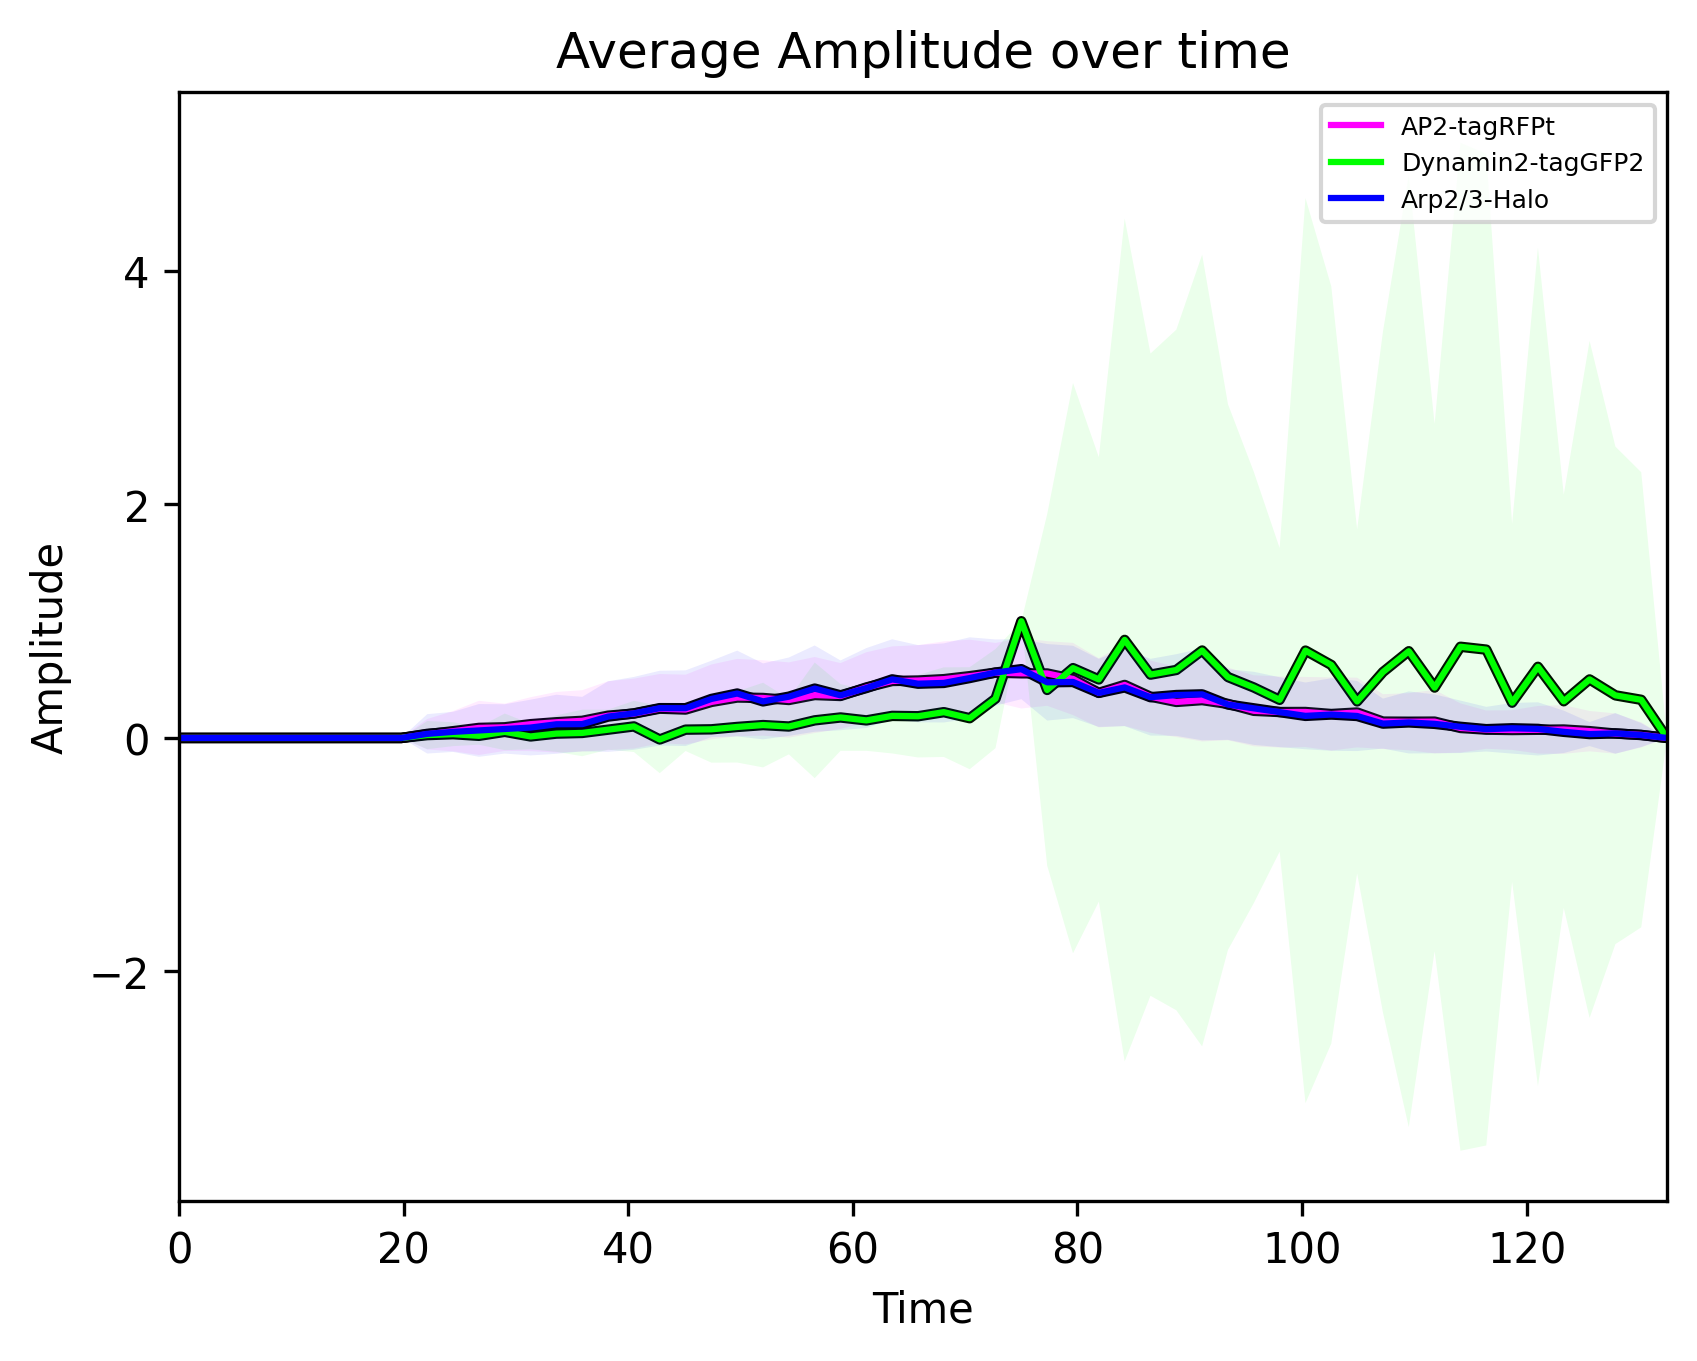

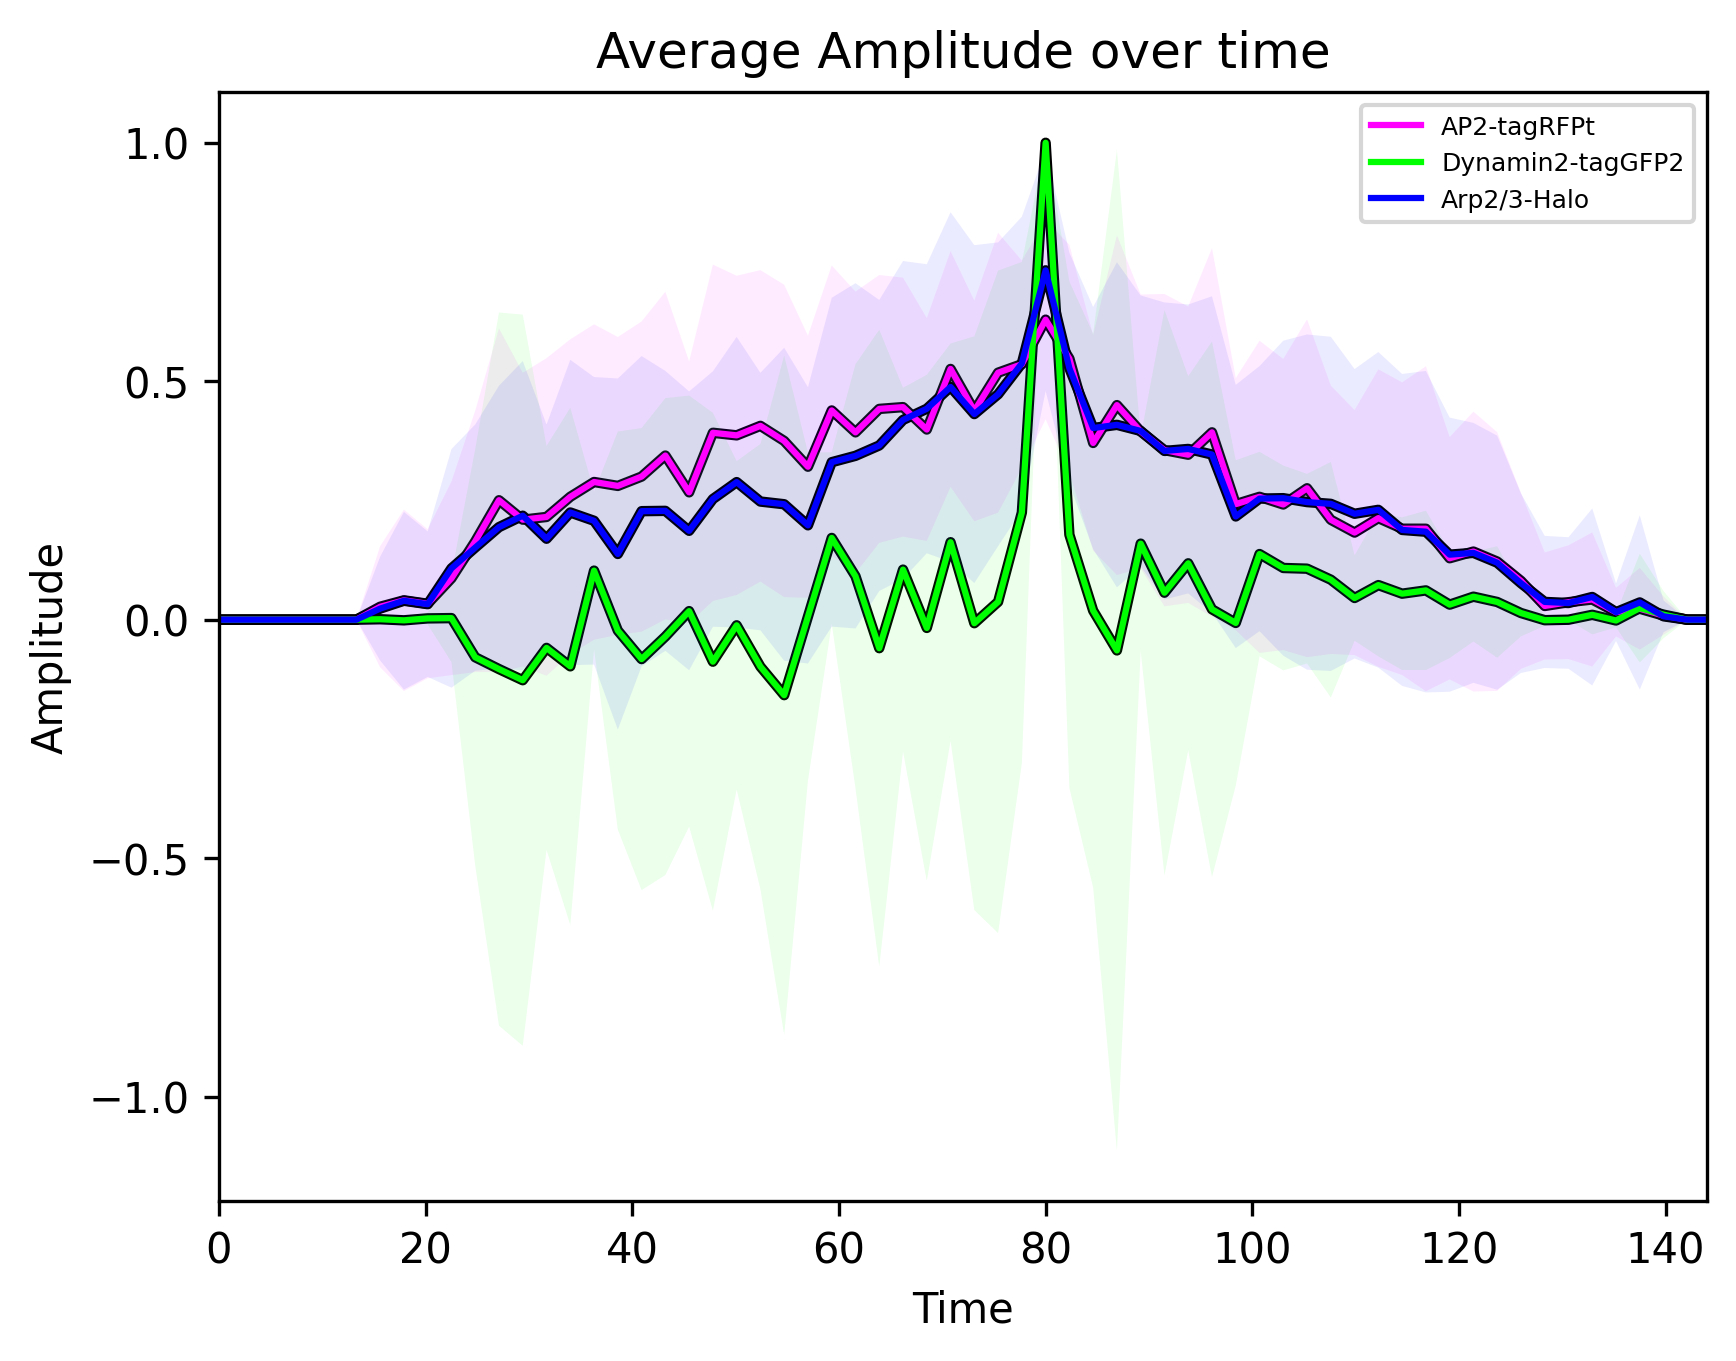

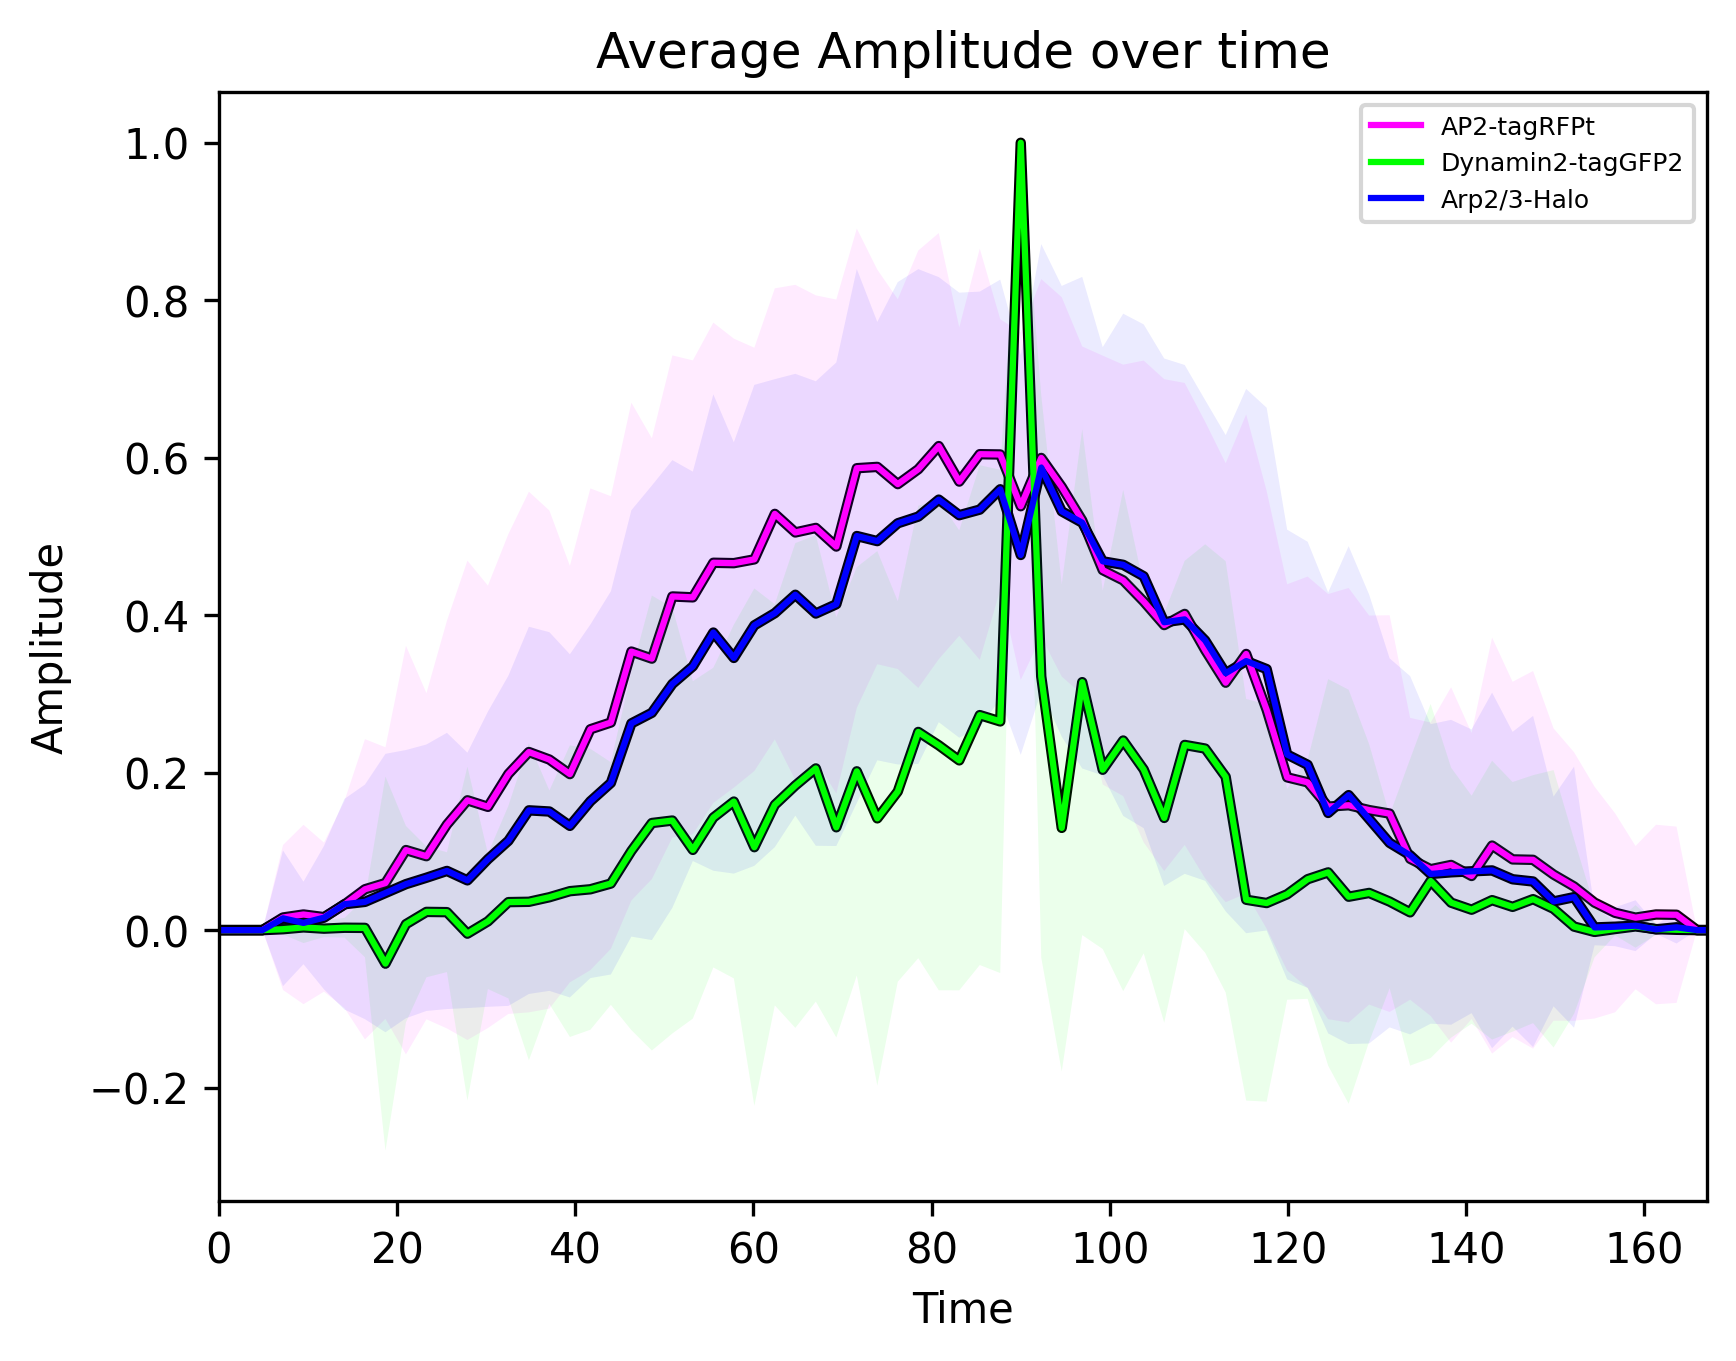

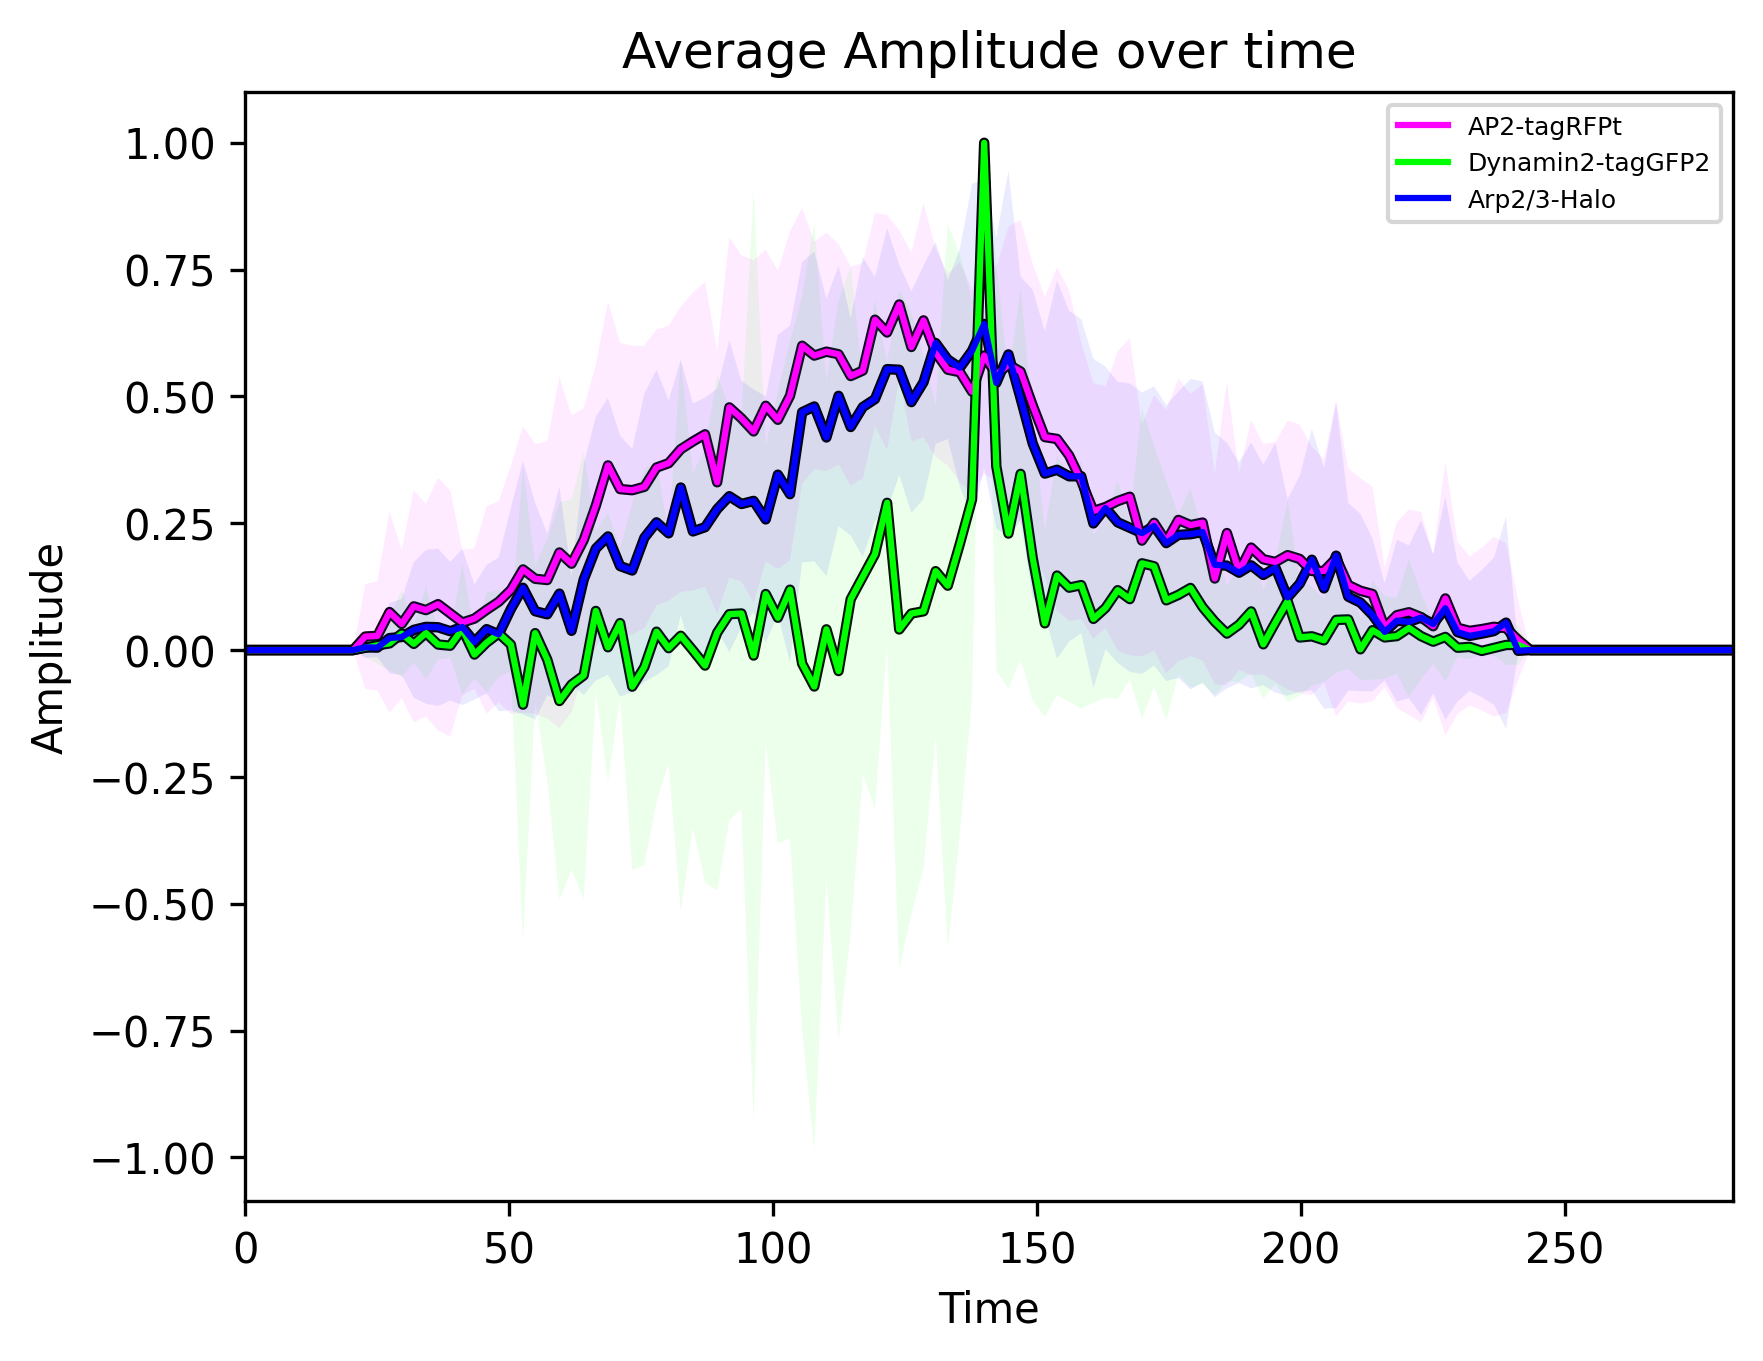

In [30]:
for n, cohort in enumerate(custom_length_ranges):
    primary_buffer, secondary_buffer, tertiary_buffer = createBufferForLifetimeCohort_normalized(dataframe = track_df ,
    listOfTrackIdsAssignedToCohort = track_id_arrays[n], backgroundIntensity = [background_channel_3, background_channel_2, background_channel_1], 
    # intensity_to_plot = ['c3_voxel_sum_adjusted','c2_voxel_sum_adjusted', 'c1_voxel_sum_adjusted'], track_id_col_name = 'track_id')
    intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id')

    cumulative_plots(buffers = [primary_buffer, secondary_buffer, tertiary_buffer],
    background_intensity= [background_channel_3, background_channel_2, background_channel_1], time_shift = 50+cohort[1], framerate_msec = framerate_msec, colors = ['magenta', 'lime', 'blue'], 
                    legend_vals = [channel3_name, channel2_name, channel1_name])
    plt.xlim(0, 75+cohort[1]*framerate_msec/1000)


In [17]:
# Plot each membrane region separately